# 3D Multi-class Segmentation with UNETR  (Muscle, Fat (subcut and internal), psoas,cavity and Bgd)

## Setup environment

In [1]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import UNETR

from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)


import torch

print_config()

MONAI version: 0.10.dev2231
Numpy version: 1.23.1
Pytorch version: 1.12.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 8236821c099e5997f7ad0410c5374e4472f4ed14
MONAI __file__: /home/adminbthomas/miniconda3/envs/PT02/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.9
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.2.0
Tensorboard version: 2.9.1
gdown version: 4.5.1
TorchVision version: 0.13.0+cu102
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.4.3
einops version: 0.4.1
transformers version: 4.20.1
mlflow version: 1.27.0
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory


In [3]:
# directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = "/home/adminbthomas/Downloads/data"# root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/home/adminbthomas/Downloads/data


## Setup transforms for training and validation

In [4]:
import datetime
import time

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
#         AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 4.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=0,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,   # change-intermedouts 
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 16),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
        ToTensord(keys=["image", "label"]),
        SaveImaged(keys="image", meta_keys="image_meta_dict", output_dir="./outMR02_Jul23_Interinputs", output_postfix=datetime.datetime.now().strftime('%f'), resample=False, separate_folder=False),
        SaveImaged(keys="label", meta_keys="label_meta_dict", output_dir="./outMR02_Jul23_Interinputs", output_postfix=datetime.datetime.now().strftime('%f'), resample=False, separate_folder=False),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
#         AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 4.0),
            mode=("bilinear", "nearest"),
        ),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=250, b_min=0.0, b_max=1.0, clip=True
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        ToTensord(keys=["image", "label"]),
    ]
)

### DATA

In [5]:
data_dir = os.path.join(root_dir,"013123_MR/")

In [6]:
# data_dir = os.path.join(root_dir,"013123_MR/")
split_JSON = "dataset_MR.json"
datasets = data_dir + split_JSON
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True, num_workers=8, pin_memory=True
)
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4
)
val_loader = DataLoader(
    val_ds, batch_size=1, shuffle=False, num_workers=4, pin_memory=True
)

Loading dataset:   0%|                                                                                                                                                        | 0/20 [00:00<?, ?it/s]Modifying image pixdim from [1.4648438 1.4648438 8.        0.       ] to [  1.46484375   1.46484375   8.         281.03604124]
Modifying image pixdim from [1.4648438 1.4648438 4.        0.       ] to [  1.46484375   1.46484375   4.         268.45717811]
Loading dataset: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.04it/s]


In [7]:
data_dir = os.path.join(root_dir,"013123_MR/")
print(data_dir)
# help(val_loader)

/home/adminbthomas/Downloads/data/013123_MR/


## Check data shape and visualize

In [8]:
# slice_map = {
#     "A051_v2_T2W.nii.gz": 10,
#     "A051_v2_T2W.nii.gz": 8,
#     "A051_v2_T2W.nii.gz": 6
# }
# case_num = 3
# img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
# img = val_ds[case_num]["image"]
# label = val_ds[case_num]["label"]
# img_shape = img.shape
# label_shape = label.shape
# print(f"image shape: {img_shape}, label shape: {label_shape}")
# plt.figure("image", (18, 6))
# plt.subplot(1, 2, 1)
# plt.title("image")
# plt.imshow(img[0, :, :, slice_map[img_name]].detach().cpu(), cmap="gray")
# plt.subplot(1, 2, 2)
# plt.title("label")
# plt.imshow(label[0, :, :, slice_map[img_name]].detach().cpu())
# plt.show()

### Create Model, Loss, Optimizer


In [9]:
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda:0")

model = UNETR(
    in_channels=1,
    out_channels=6,
    img_size=(96, 96, 16),
    feature_size=16,
    hidden_size=768,
    mlp_dim=3072,
    num_heads=12,
    pos_embed="perceptron",
    norm_name="instance",
    res_block=True,
    dropout_rate=0.0,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

### Execute a typical PyTorch training process

Training (X / X Steps) (loss=X.X):   0%|                                                                                                                                      | 0/20 [00:00<?, ?it/s]

2023-07-25 15:43:15,177 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A051_v2_T2W_829433.nii.gz
2023-07-25 15:43:15,191 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A024_v1_T2W_829433.nii.gz
2023-07-25 15:43:15,190 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A016_v3_T2W_829433.nii.gz
2023-07-25 15:43:15,243 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A034_v5_T2W_829433.nii.gz
2023-07-25 15:43:15,238 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A065_v2_T2W_829433.nii.gz
2023-07-25 15:43:15,247 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A052_v1_T2W_829433.nii.gz
2023-07-25 15:43:15,268 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A043_v5_T2W_829433.nii.gz
2023-07-25 15:43:15,305 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A051_v2_T2W_829433.nii.gz
2023-07-25 15:43:15,330 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A016_v3_T2W_829433

2023-07-25 15:43:15,687 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A071_v2_T2W_829433.nii.gz
2023-07-25 15:43:15,695 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A029_v4_T2W_829433.nii.gz
2023-07-25 15:43:15,700 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A061_v5_T2W_829433.nii.gz
2023-07-25 15:43:15,683 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A014_v2_T2W_829433.nii.gz
2023-07-25 15:43:15,704 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A037_v1_T2W_829433.nii.gz
2023-07-25 15:43:15,715 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A002_v3_T2W_829433.nii.gz
2023-07-25 15:43:15,713 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A009_v4_T2W_829433.nii.gz
2023-07-25 15:43:15,726 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A029_v4_T2W_829433.nii.gz
2023-07-25 15:43:15,728 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A071_v2_T2W_829433

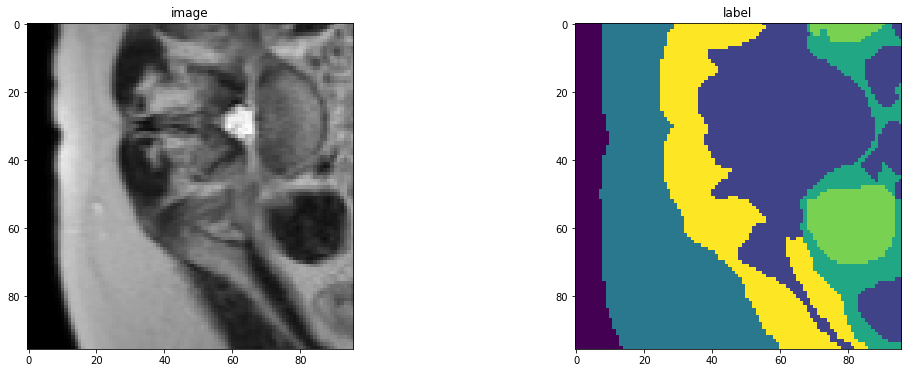

Training (0 / 70 Steps) (loss=2.53863):   5%|██████                                                                                                                   | 1/20 [00:02<00:55,  2.94s/it]

2023-07-25 15:43:17,650 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A023_v5_T2W_829433.nii.gz
torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])
2023-07-25 15:43:17,687 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A023_v5_T2W_829433.nii.gz
2023-07-25 15:43:17,707 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A023_v5_T2W_829433.nii.gz
2023-07-25 15:43:17,728 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A023_v5_T2W_829433.nii.gz
2023-07-25 15:43:17,748 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A023_v5_T2W_seg_829587.nii.gz
2023-07-25 15:43:17,753 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A023_v5_T2W_seg_829587.nii.gz
2023-07-25 15:43:17,757 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A023_v5_T2W_seg_829587.nii.gz
2023-07-25 15:43:17,762 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A023_v5_T2W_seg_829587.nii.gz


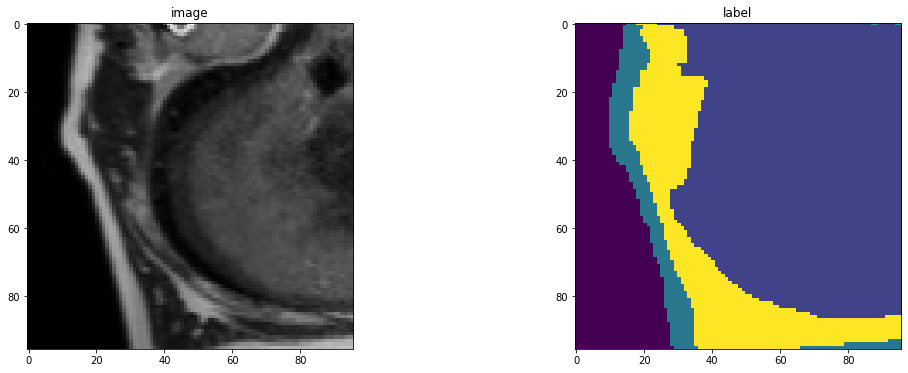

Training (1 / 70 Steps) (loss=2.47211):  10%|████████████                                                                                                             | 2/20 [00:03<00:27,  1.51s/it]

2023-07-25 15:43:18,163 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A026_v1_T2W_829433.nii.gz
2023-07-25 15:43:18,184 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A026_v1_T2W_829433.nii.gz
2023-07-25 15:43:18,203 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A026_v1_T2W_829433.nii.gz
2023-07-25 15:43:18,222 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A026_v1_T2W_829433.nii.gz
torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


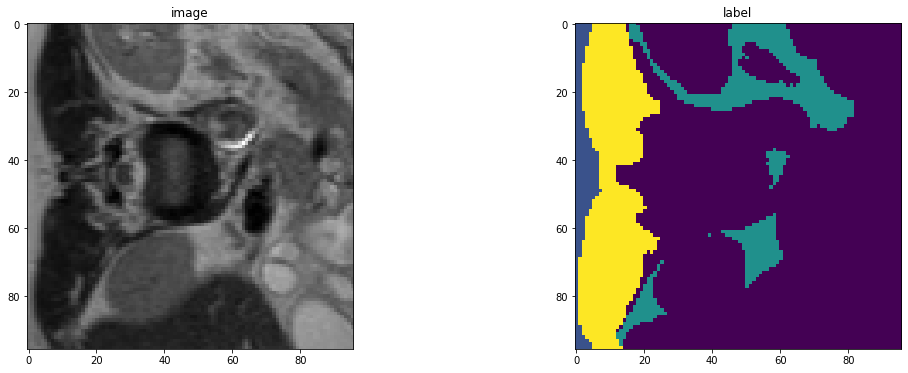

2023-07-25 15:43:18,262 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/segA026_v1_T2W_829587.nii.gz
2023-07-25 15:43:18,268 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/segA026_v1_T2W_829587.nii.gz
2023-07-25 15:43:18,273 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/segA026_v1_T2W_829587.nii.gz
2023-07-25 15:43:18,277 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/segA026_v1_T2W_829587.nii.gz


Training (2 / 70 Steps) (loss=2.42999):  15%|██████████████████▏                                                                                                      | 3/20 [00:03<00:16,  1.06it/s]

2023-07-25 15:43:18,428 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A028_v5_T2W_829433.nii.gz
2023-07-25 15:43:18,449 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A028_v5_T2W_829433.nii.gz
2023-07-25 15:43:18,469 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A028_v5_T2W_829433.nii.gz
2023-07-25 15:43:18,489 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A028_v5_T2W_829433.nii.gz
2023-07-25 15:43:18,509 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/segA028_v5_T2W_829587.nii.gz
2023-07-25 15:43:18,514 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/segA028_v5_T2W_829587.nii.gz
torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


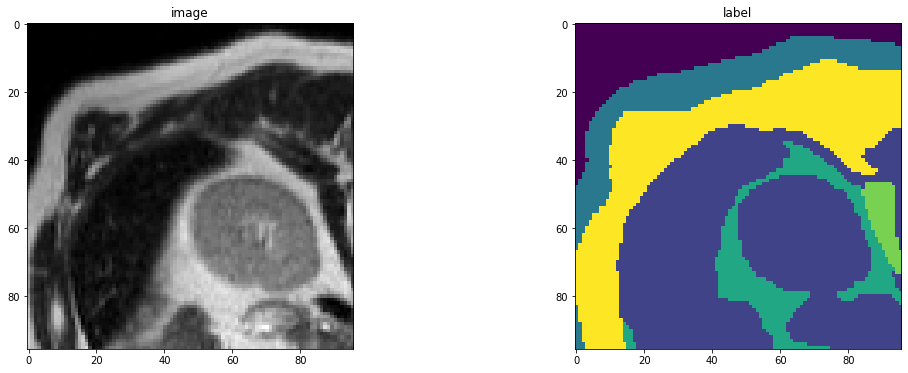

2023-07-25 15:43:18,524 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/segA028_v5_T2W_829587.nii.gz
2023-07-25 15:43:18,533 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/segA028_v5_T2W_829587.nii.gz


Training (3 / 70 Steps) (loss=2.50311):  20%|████████████████████████▏                                                                                                | 4/20 [00:04<00:10,  1.46it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


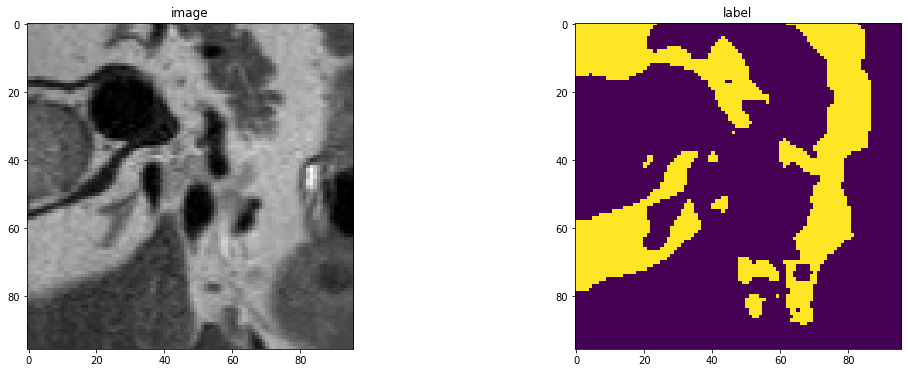

Training (4 / 70 Steps) (loss=2.49684):  25%|██████████████████████████████▎                                                                                          | 5/20 [00:04<00:08,  1.84it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


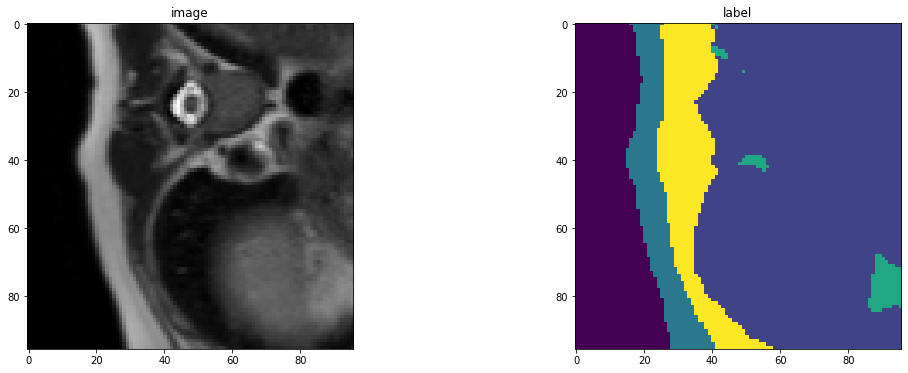

Training (5 / 70 Steps) (loss=2.34192):  30%|████████████████████████████████████▎                                                                                    | 6/20 [00:04<00:06,  2.19it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


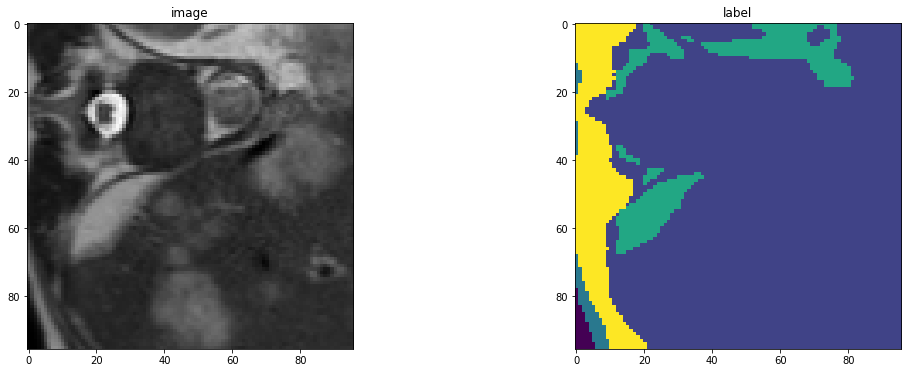

Training (6 / 70 Steps) (loss=2.43209):  35%|██████████████████████████████████████████▎                                                                              | 7/20 [00:04<00:05,  2.55it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


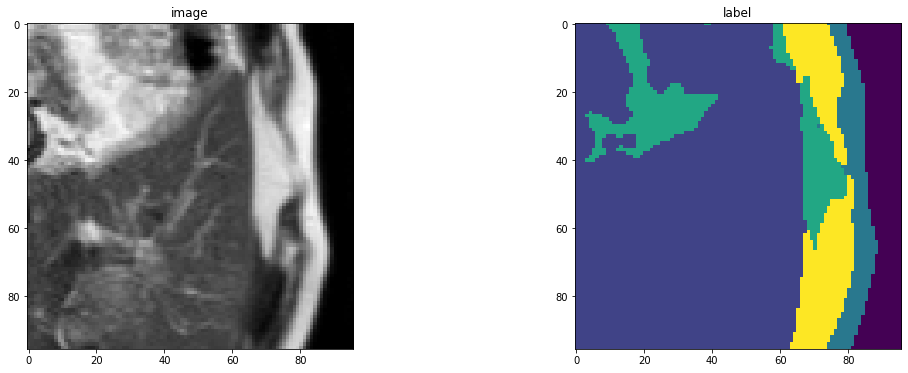

Training (7 / 70 Steps) (loss=2.32330):  40%|████████████████████████████████████████████████▍                                                                        | 8/20 [00:05<00:04,  2.85it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


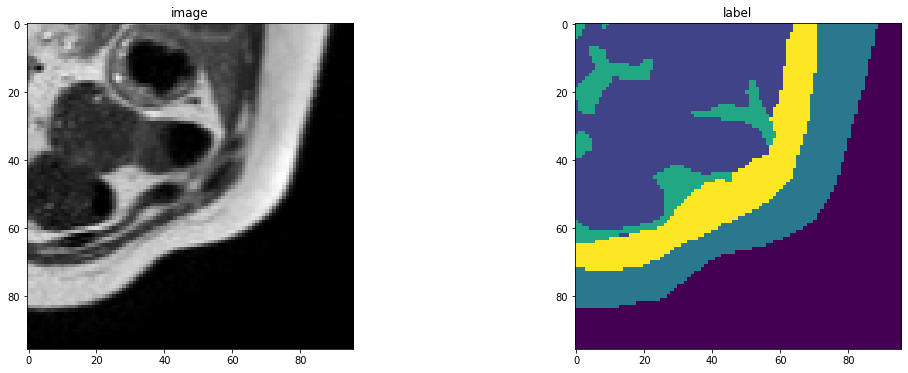

Training (8 / 70 Steps) (loss=2.31822):  45%|██████████████████████████████████████████████████████▍                                                                  | 9/20 [00:05<00:03,  3.04it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


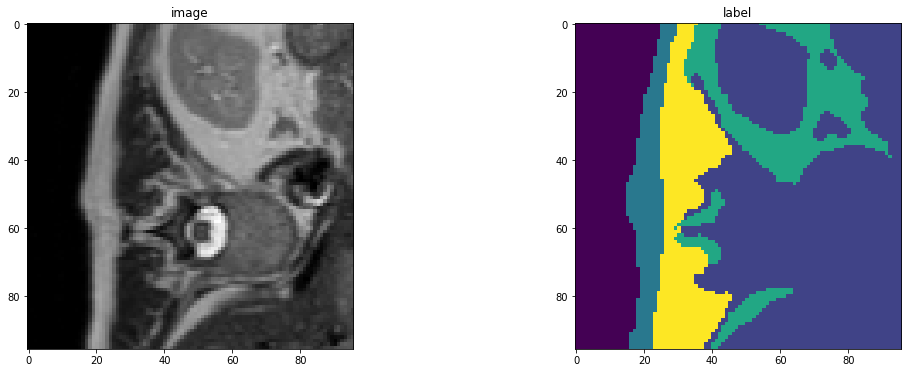

Training (9 / 70 Steps) (loss=2.31363):  50%|████████████████████████████████████████████████████████████                                                            | 10/20 [00:05<00:03,  3.20it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


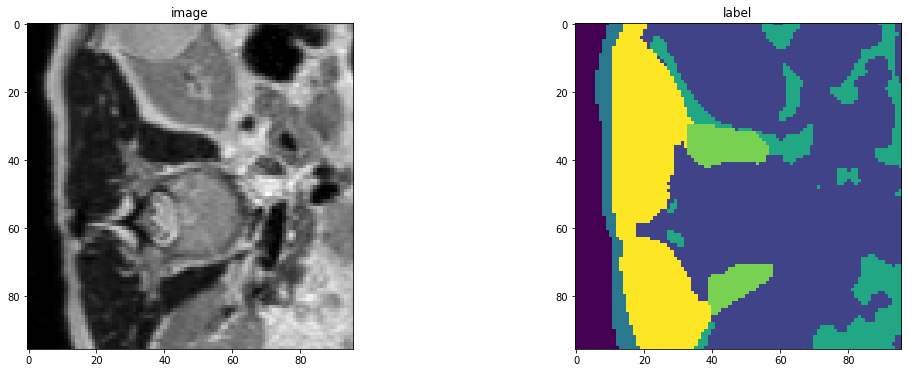

Training (10 / 70 Steps) (loss=2.38527):  55%|█████████████████████████████████████████████████████████████████▍                                                     | 11/20 [00:05<00:02,  3.25it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


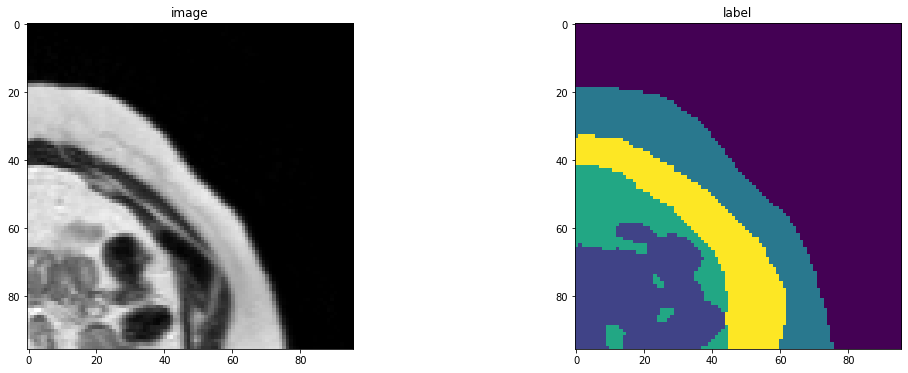

Training (11 / 70 Steps) (loss=2.29561):  60%|███████████████████████████████████████████████████████████████████████▍                                               | 12/20 [00:06<00:02,  3.34it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


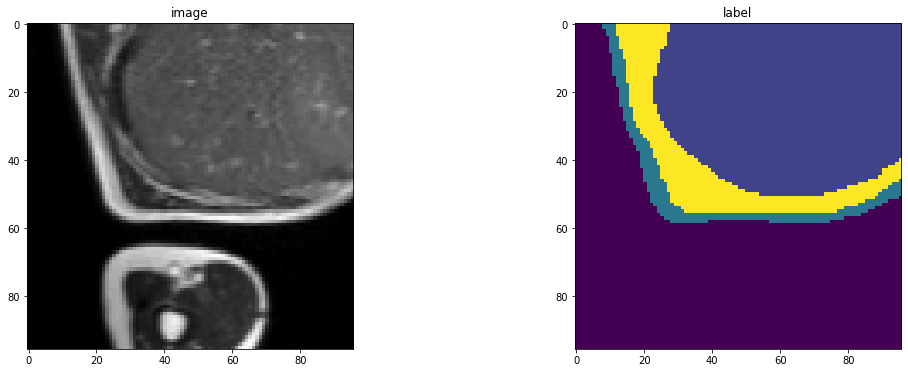

Training (12 / 70 Steps) (loss=2.31224):  65%|█████████████████████████████████████████████████████████████████████████████▎                                         | 13/20 [00:06<00:02,  3.36it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


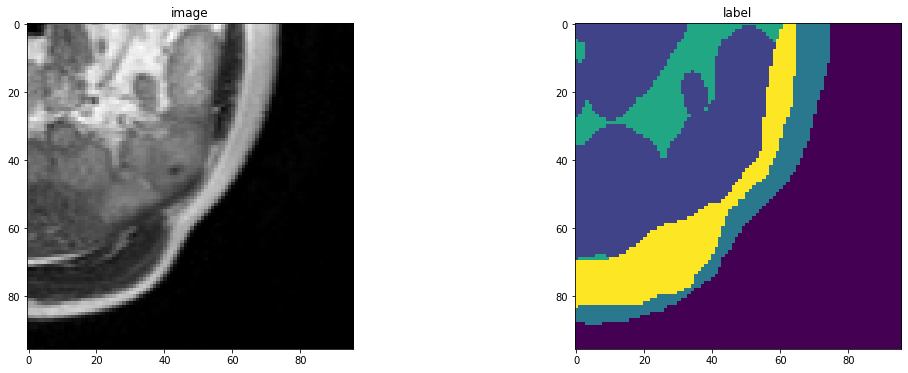

Training (13 / 70 Steps) (loss=2.28426):  70%|███████████████████████████████████████████████████████████████████████████████████▎                                   | 14/20 [00:06<00:01,  3.45it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


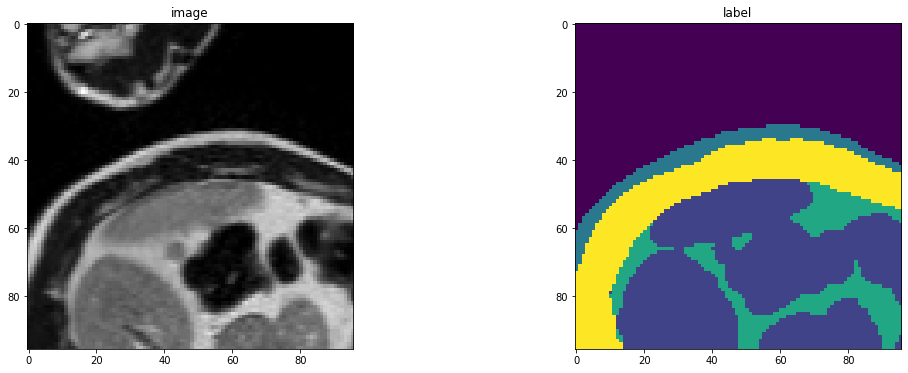

Training (14 / 70 Steps) (loss=2.30713):  75%|█████████████████████████████████████████████████████████████████████████████████████████▎                             | 15/20 [00:07<00:01,  3.47it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


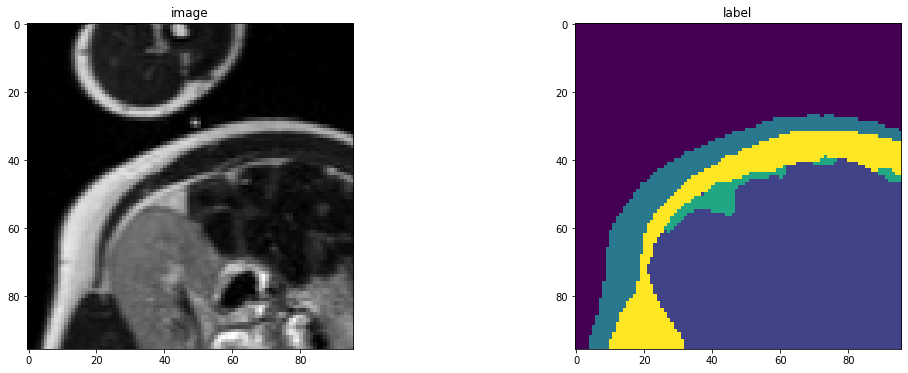

Training (15 / 70 Steps) (loss=2.21139):  80%|███████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/20 [00:07<00:01,  3.50it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


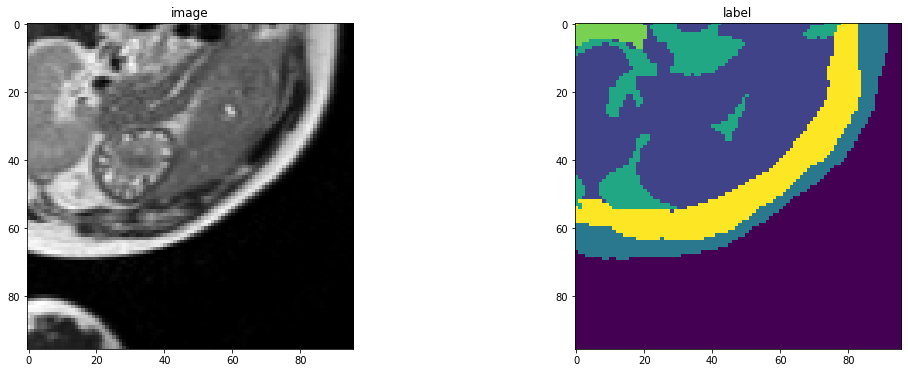

Training (16 / 70 Steps) (loss=2.10629):  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 17/20 [00:07<00:00,  3.52it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


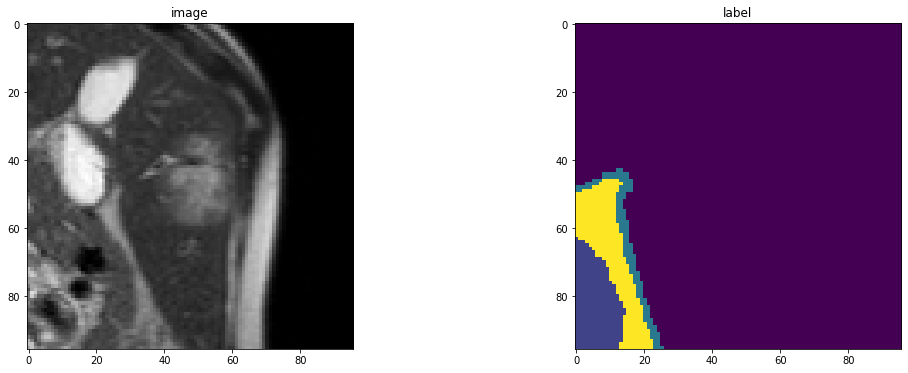

Training (17 / 70 Steps) (loss=2.88815):  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████            | 18/20 [00:08<00:00,  3.06it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


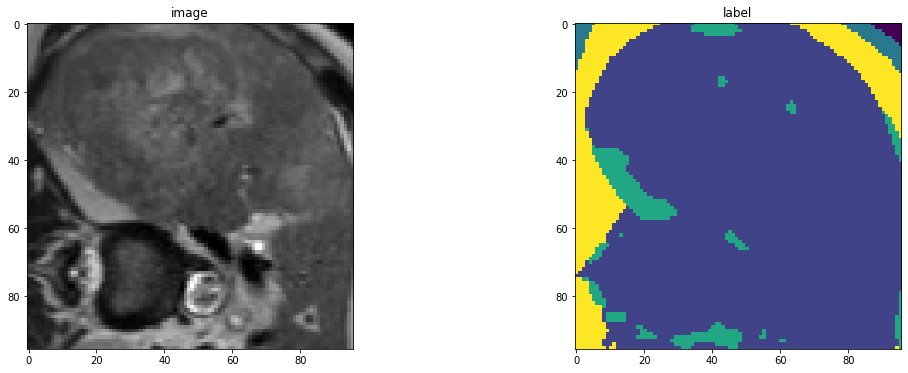

Training (18 / 70 Steps) (loss=2.15387):  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 19/20 [00:08<00:00,  3.21it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


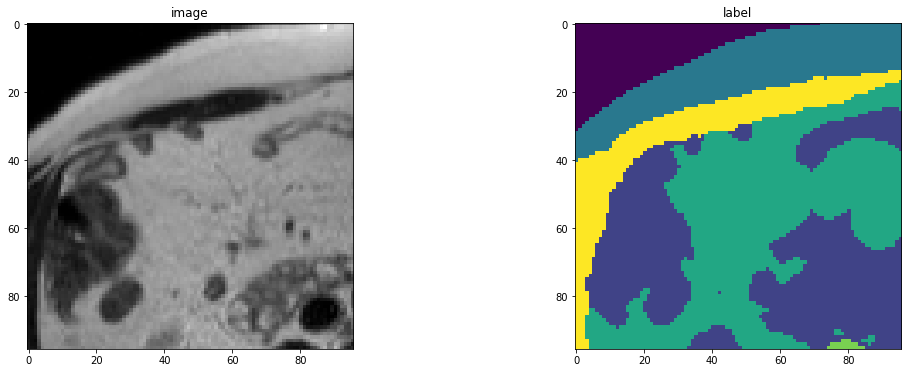

Training (X / X Steps) (loss=X.X):   0%|                                                                                                                                      | 0/20 [00:00<?, ?it/s]

2023-07-25 15:43:23,806 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A016_v3_T2W_829433.nii.gz
2023-07-25 15:43:23,853 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A051_v2_T2W_829433.nii.gz
2023-07-25 15:43:23,866 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A037_v1_T2W_829433.nii.gz
2023-07-25 15:43:23,880 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A061_v5_T2W_829433.nii.gz
2023-07-25 15:43:23,881 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A026_v1_T2W_829433.nii.gz
2023-07-25 15:43:23,899 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A016_v3_T2W_829433.nii.gz
2023-07-25 15:43:23,931 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A065_v2_T2W_829433.nii.gz
2023-07-25 15:43:23,951 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A034_v5_T2W_829433.nii.gz
2023-07-25 15:43:23,965 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A043_v5_T2W_829433

2023-07-25 15:43:24,321 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A013_v1_T2W_829433.nii.gz
2023-07-25 15:43:24,339 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A022_v4_T2W_829433.nii.gz
2023-07-25 15:43:24,342 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A009_v4_T2W_829433.nii.gz
2023-07-25 15:43:24,298 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A002_v3_T2W_829433.nii.gz
2023-07-25 15:43:24,353 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A071_v2_T2W_829433.nii.gz
2023-07-25 15:43:24,357 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A033_v3_T2W_829433.nii.gz
2023-07-25 15:43:24,361 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A052_v1_T2W_829433.nii.gz
2023-07-25 15:43:24,380 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A022_v4_T2W_829433.nii.gz
2023-07-25 15:43:24,396 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A013_v1_T2W_829433

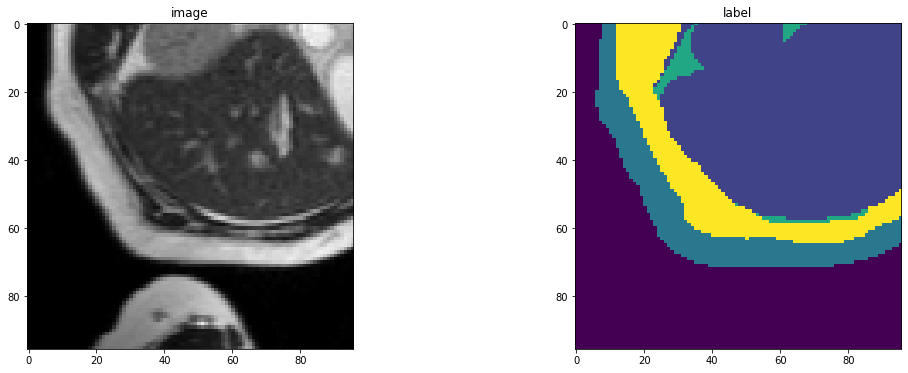

2023-07-25 15:43:24,674 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A023_v5_T2W_829433.nii.gz
2023-07-25 15:43:24,699 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A023_v5_T2W_seg_829587.nii.gz
2023-07-25 15:43:24,704 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A023_v5_T2W_seg_829587.nii.gz
2023-07-25 15:43:24,708 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A023_v5_T2W_seg_829587.nii.gz
2023-07-25 15:43:24,713 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A023_v5_T2W_seg_829587.nii.gz


Training (20 / 70 Steps) (loss=2.13406):   5%|██████                                                                                                                  | 1/20 [00:01<00:27,  1.45s/it]

2023-07-25 15:43:24,843 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A028_v5_T2W_829433.nii.gz
2023-07-25 15:43:24,882 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A028_v5_T2W_829433.nii.gz
2023-07-25 15:43:24,904 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A028_v5_T2W_829433.nii.gz
2023-07-25 15:43:24,923 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A028_v5_T2W_829433.nii.gz
2023-07-25 15:43:24,944 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/segA028_v5_T2W_829587.nii.gz
2023-07-25 15:43:24,949 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/segA028_v5_T2W_829587.nii.gz
2023-07-25 15:43:24,955 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/segA028_v5_T2W_829587.nii.gz
2023-07-25 15:43:24,960 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/segA028_v5_T2W_829587.nii.gz
torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


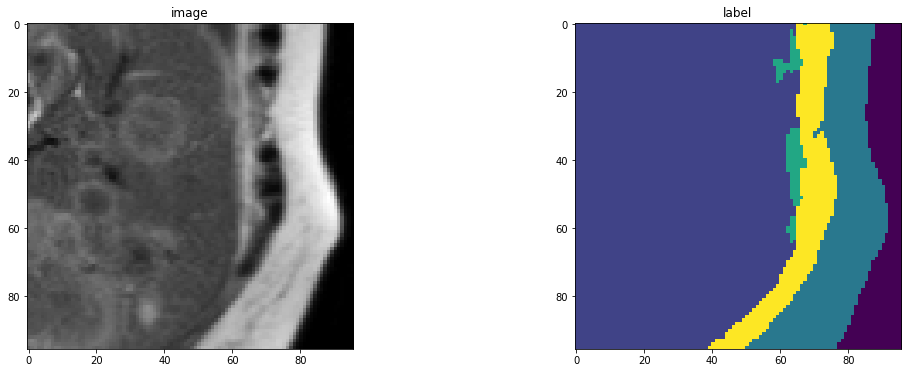

Training (21 / 70 Steps) (loss=2.08086):  10%|████████████                                                                                                            | 2/20 [00:01<00:14,  1.27it/s]

2023-07-25 15:43:25,186 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A024_v1_T2W_829433.nii.gz
2023-07-25 15:43:25,208 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A024_v1_T2W_829433.nii.gz
2023-07-25 15:43:25,236 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A024_v1_T2W_829433.nii.gz
2023-07-25 15:43:25,257 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A024_v1_T2W_829433.nii.gz
2023-07-25 15:43:25,279 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A024_v1_T2W_seg_829587.nii.gz
2023-07-25 15:43:25,284 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A024_v1_T2W_seg_829587.nii.gz
2023-07-25 15:43:25,289 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A024_v1_T2W_seg_829587.nii.gz
2023-07-25 15:43:25,295 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A024_v1_T2W_seg_829587.nii.gz
torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


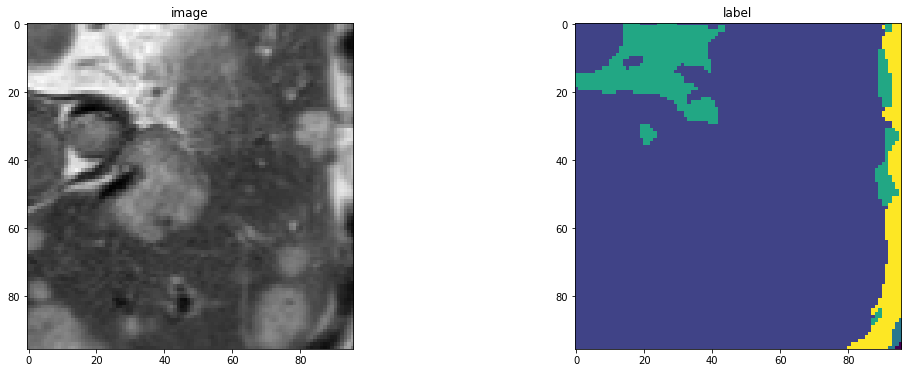

Training (22 / 70 Steps) (loss=2.18337):  15%|██████████████████                                                                                                      | 3/20 [00:02<00:09,  1.71it/s]

2023-07-25 15:43:25,512 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A029_v4_T2W_829433.nii.gz
2023-07-25 15:43:25,534 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A029_v4_T2W_829433.nii.gz
2023-07-25 15:43:25,553 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A029_v4_T2W_829433.nii.gz
2023-07-25 15:43:25,571 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A029_v4_T2W_829433.nii.gz
2023-07-25 15:43:25,589 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/segA029_v4_T2W_829587.nii.gz
2023-07-25 15:43:25,594 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/segA029_v4_T2W_829587.nii.gz
2023-07-25 15:43:25,599 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/segA029_v4_T2W_829587.nii.gz
2023-07-25 15:43:25,604 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/segA029_v4_T2W_829587.nii.gz
torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


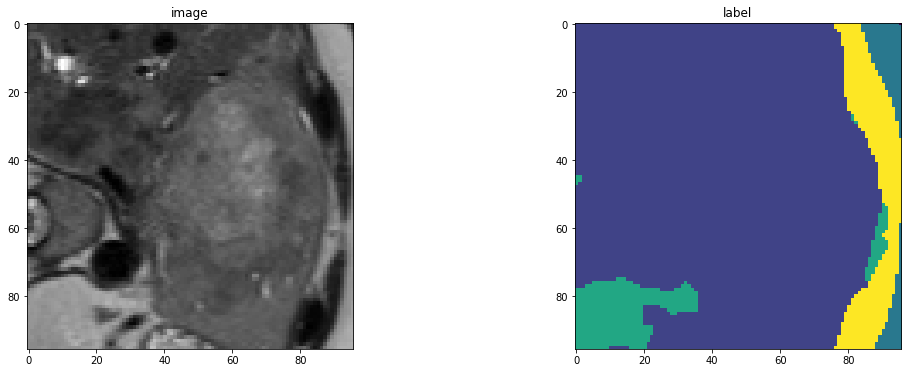

Training (23 / 70 Steps) (loss=2.10911):  20%|████████████████████████                                                                                                | 4/20 [00:02<00:07,  2.13it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


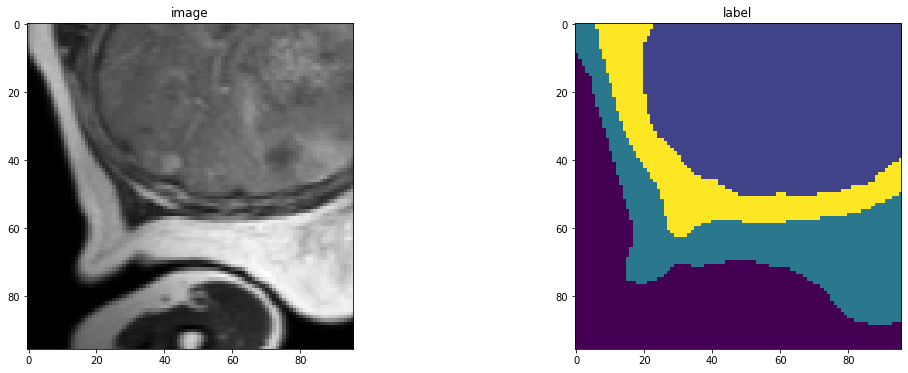

Training (24 / 70 Steps) (loss=2.04545):  25%|██████████████████████████████                                                                                          | 5/20 [00:02<00:05,  2.52it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


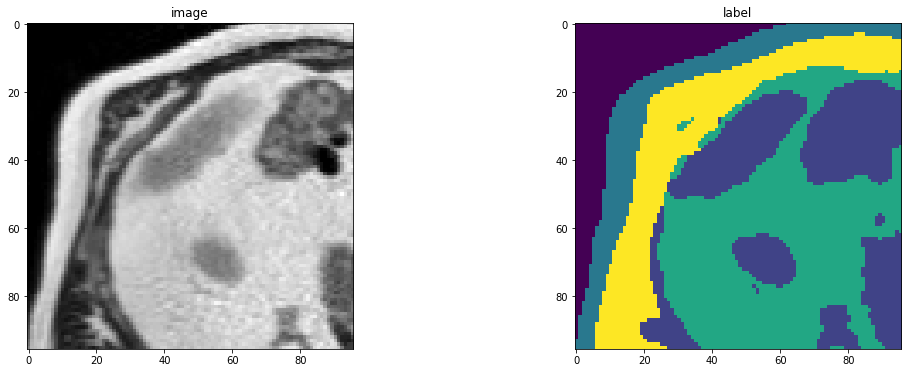

Training (25 / 70 Steps) (loss=2.15394):  30%|████████████████████████████████████                                                                                    | 6/20 [00:02<00:04,  2.81it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


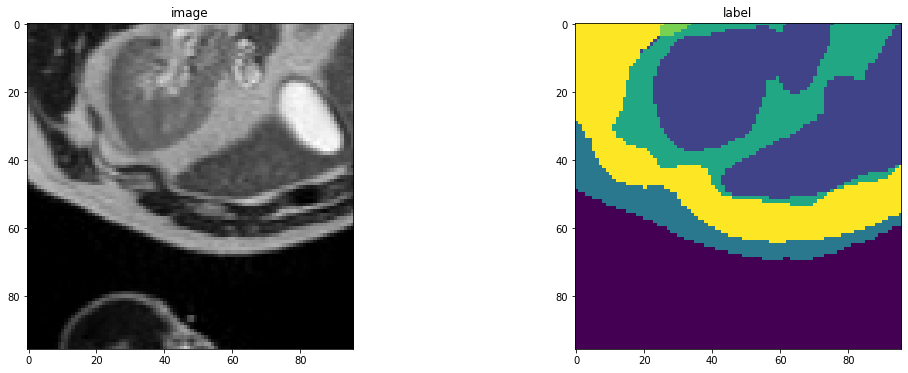

Training (26 / 70 Steps) (loss=2.12262):  35%|██████████████████████████████████████████                                                                              | 7/20 [00:03<00:04,  3.07it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


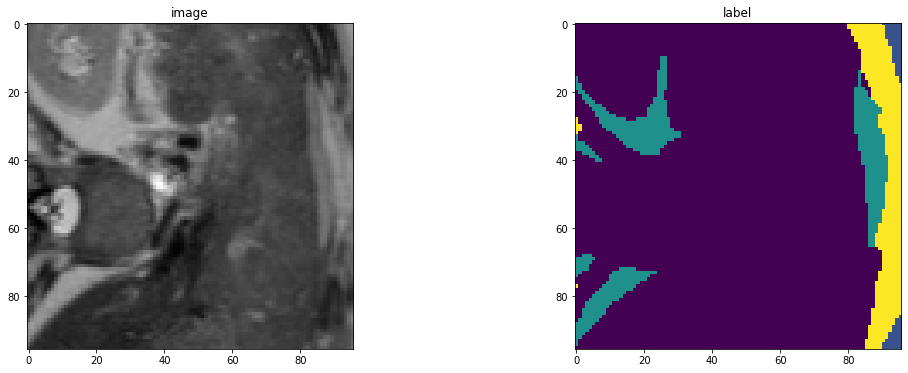

Training (27 / 70 Steps) (loss=2.16274):  40%|████████████████████████████████████████████████                                                                        | 8/20 [00:03<00:03,  3.28it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


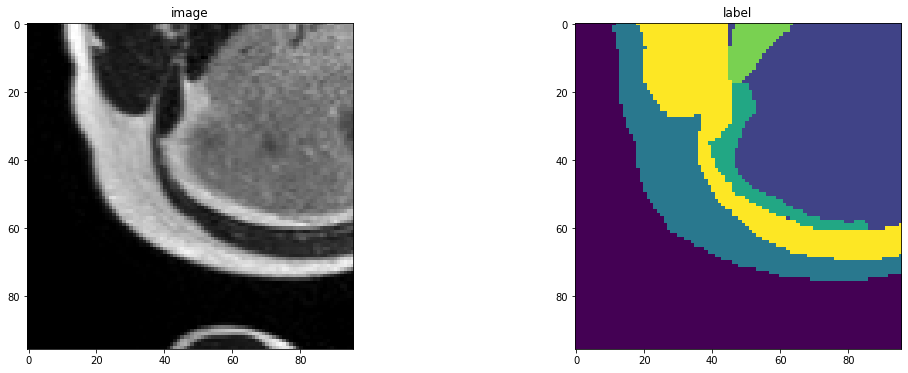

Training (28 / 70 Steps) (loss=2.04961):  45%|██████████████████████████████████████████████████████                                                                  | 9/20 [00:03<00:03,  3.43it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


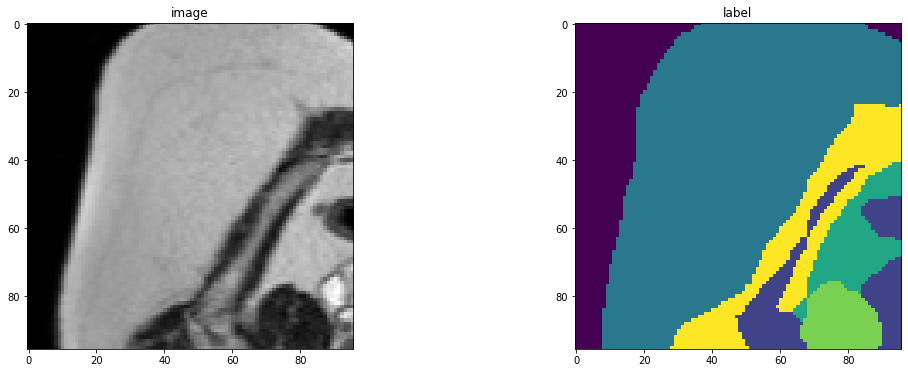

Training (29 / 70 Steps) (loss=2.20751):  50%|███████████████████████████████████████████████████████████▌                                                           | 10/20 [00:03<00:02,  3.55it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


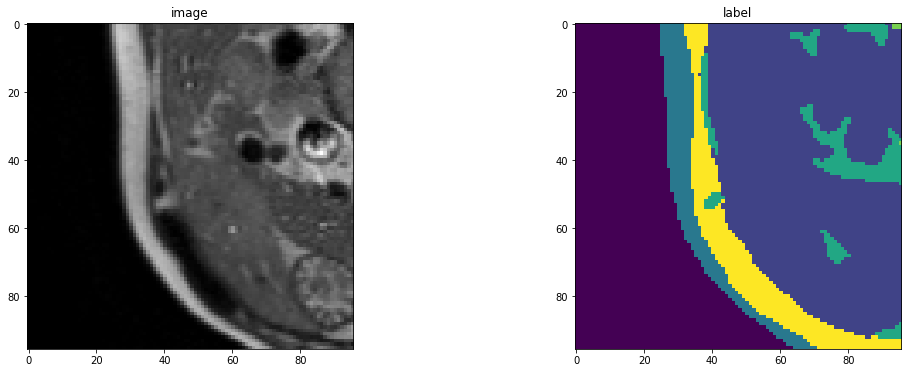

Training (30 / 70 Steps) (loss=2.04187):  55%|█████████████████████████████████████████████████████████████████▍                                                     | 11/20 [00:04<00:02,  3.63it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


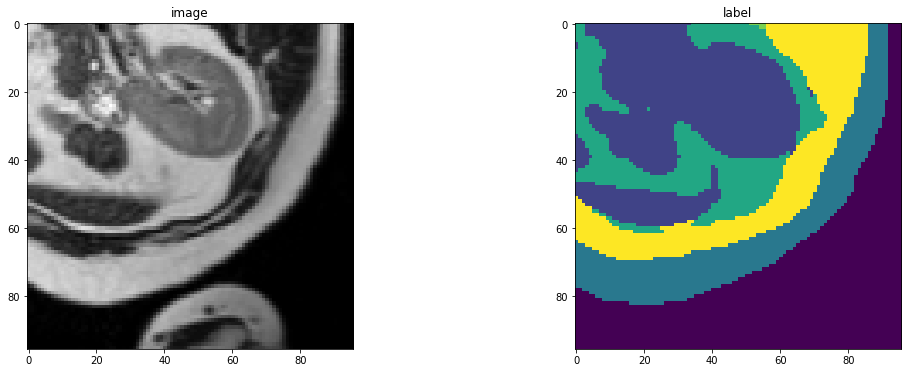

Training (31 / 70 Steps) (loss=2.03543):  60%|███████████████████████████████████████████████████████████████████████▍                                               | 12/20 [00:04<00:02,  3.09it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


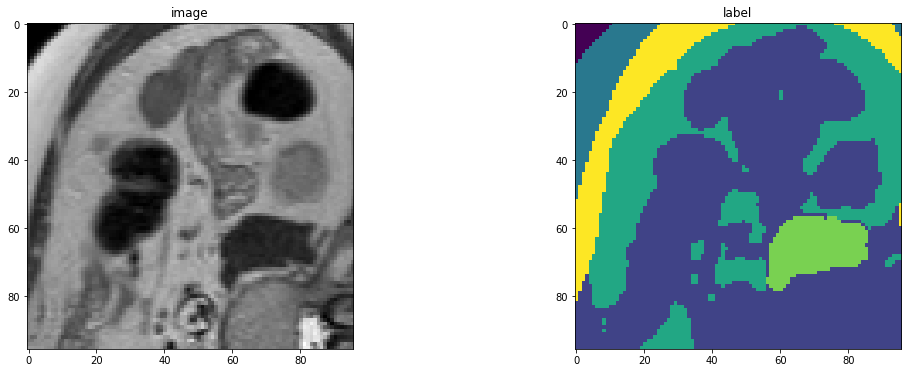

Training (32 / 70 Steps) (loss=2.13953):  65%|█████████████████████████████████████████████████████████████████████████████▎                                         | 13/20 [00:04<00:02,  3.28it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


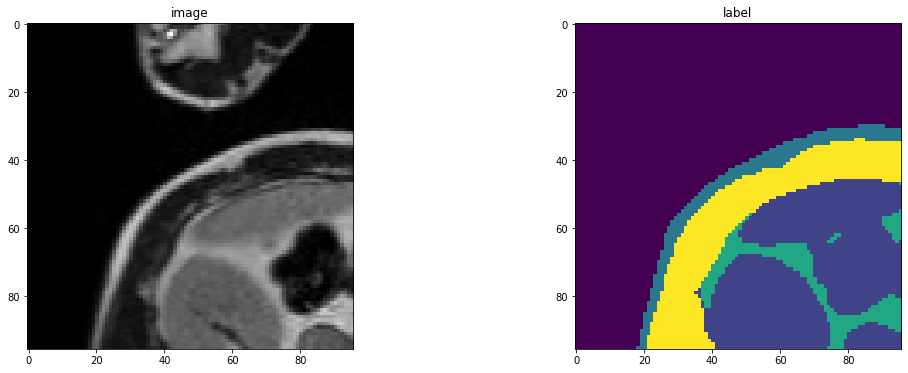

Training (33 / 70 Steps) (loss=2.11457):  70%|███████████████████████████████████████████████████████████████████████████████████▎                                   | 14/20 [00:05<00:01,  3.43it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


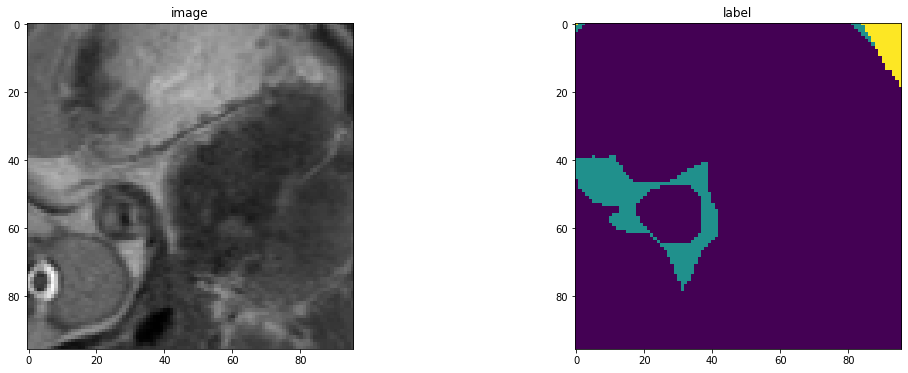

Training (34 / 70 Steps) (loss=2.29823):  75%|█████████████████████████████████████████████████████████████████████████████████████████▎                             | 15/20 [00:05<00:01,  3.39it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


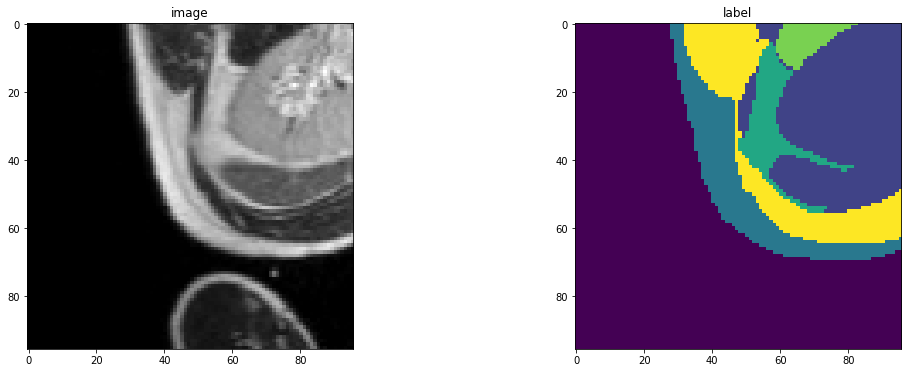

Training (35 / 70 Steps) (loss=2.13098):  80%|███████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/20 [00:05<00:01,  3.51it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


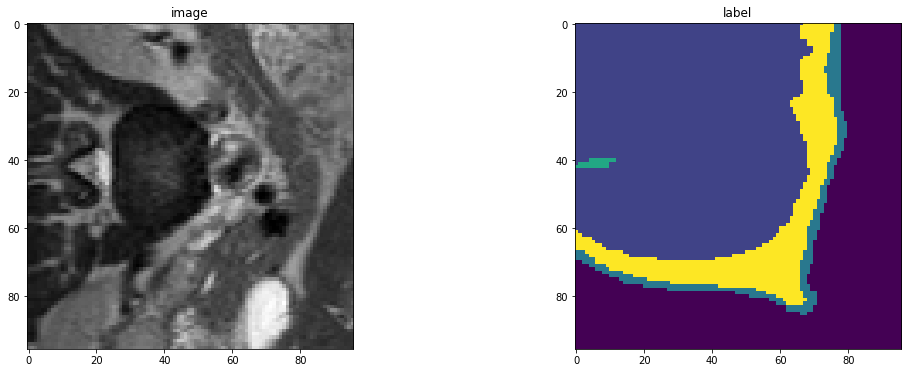

Training (36 / 70 Steps) (loss=2.81494):  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 17/20 [00:06<00:00,  3.60it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


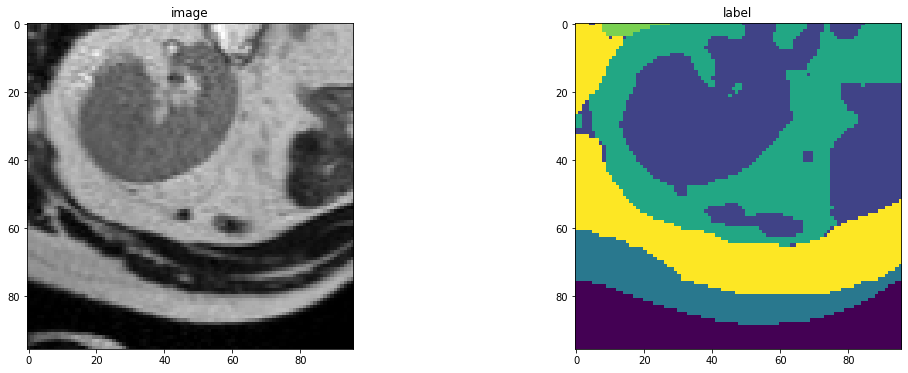

Training (37 / 70 Steps) (loss=2.10594):  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████            | 18/20 [00:06<00:00,  3.67it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


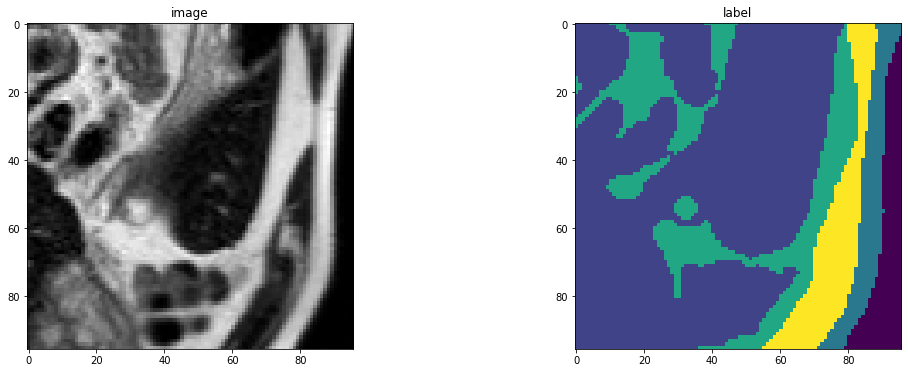

Training (38 / 70 Steps) (loss=2.13440):  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 19/20 [00:06<00:00,  3.73it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


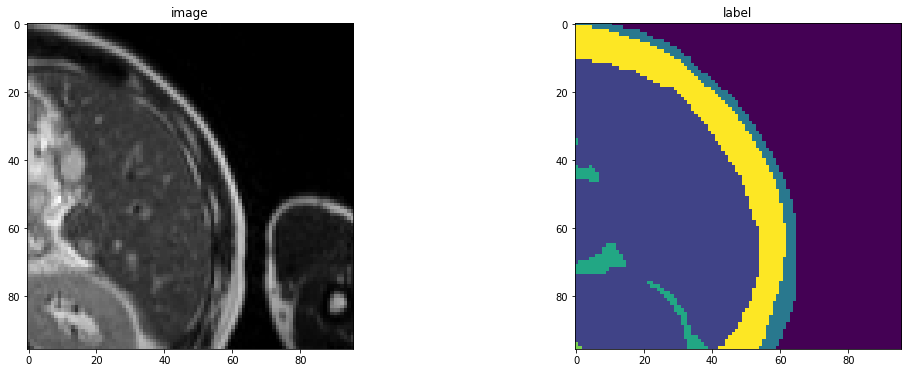

Training (X / X Steps) (loss=X.X):   0%|                                                                                                                                      | 0/20 [00:00<?, ?it/s]

2023-07-25 15:43:30,767 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A028_v5_T2W_829433.nii.gz
2023-07-25 15:43:30,789 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A014_v2_T2W_829433.nii.gz
2023-07-25 15:43:30,801 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A016_v3_T2W_829433.nii.gz
2023-07-25 15:43:30,802 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A051_v2_T2W_829433.nii.gz
2023-07-25 15:43:30,804 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A029_v4_T2W_829433.nii.gz
2023-07-25 15:43:30,878 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A043_v5_T2W_829433.nii.gz
2023-07-25 15:43:30,872 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A028_v5_T2W_829433.nii.gz
2023-07-25 15:43:30,891 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A023_v5_T2W_829433.nii.gz
2023-07-25 15:43:30,884 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A037_v1_T2W_829433

2023-07-25 15:43:31,188 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A002_v3_T2W_829433.nii.gz
2023-07-25 15:43:31,237 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A013_v1_T2W_829433.nii.gz
2023-07-25 15:43:31,239 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A009_v4_T2W_829433.nii.gz
2023-07-25 15:43:31,257 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A026_v1_T2W_829433.nii.gz
2023-07-25 15:43:31,259 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A071_v2_T2W_829433.nii.gz
2023-07-25 15:43:31,249 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A065_v2_T2W_829433.nii.gz
2023-07-25 15:43:31,246 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A033_v3_T2W_829433.nii.gz
2023-07-25 15:43:31,270 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A013_v1_T2W_829433.nii.gz
2023-07-25 15:43:31,272 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A002_v3_T2W_829433

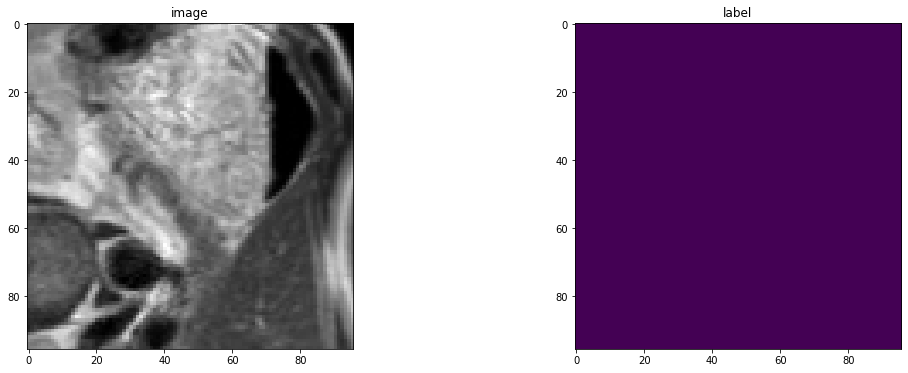

2023-07-25 15:43:31,682 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/segA034_v5_T2W_829587.nii.gz


Training (40 / 70 Steps) (loss=2.78012):   5%|██████                                                                                                                  | 1/20 [00:01<00:29,  1.58s/it]

2023-07-25 15:43:31,896 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A024_v1_T2W_829433.nii.gz
2023-07-25 15:43:31,919 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A024_v1_T2W_829433.nii.gz
2023-07-25 15:43:31,963 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A024_v1_T2W_829433.nii.gz
2023-07-25 15:43:31,987 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A024_v1_T2W_829433.nii.gz
2023-07-25 15:43:32,006 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A024_v1_T2W_seg_829587.nii.gz
2023-07-25 15:43:32,019 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A024_v1_T2W_seg_829587.nii.gz
torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


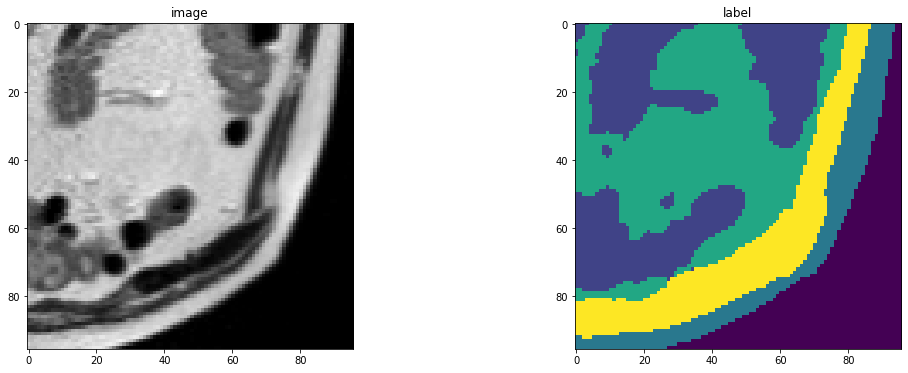

2023-07-25 15:43:32,033 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A024_v1_T2W_seg_829587.nii.gz
2023-07-25 15:43:32,042 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A024_v1_T2W_seg_829587.nii.gz


Training (41 / 70 Steps) (loss=1.99999):  10%|████████████                                                                                                            | 2/20 [00:01<00:15,  1.19it/s]

2023-07-25 15:43:32,223 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A052_v1_T2W_829433.nii.gz
2023-07-25 15:43:32,244 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A052_v1_T2W_829433.nii.gz
2023-07-25 15:43:32,264 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A052_v1_T2W_829433.nii.gz
2023-07-25 15:43:32,284 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A052_v1_T2W_829433.nii.gz
2023-07-25 15:43:32,305 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A052_v1_T2W_seg_829587.nii.gz
2023-07-25 15:43:32,310 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A052_v1_T2W_seg_829587.nii.gz
torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


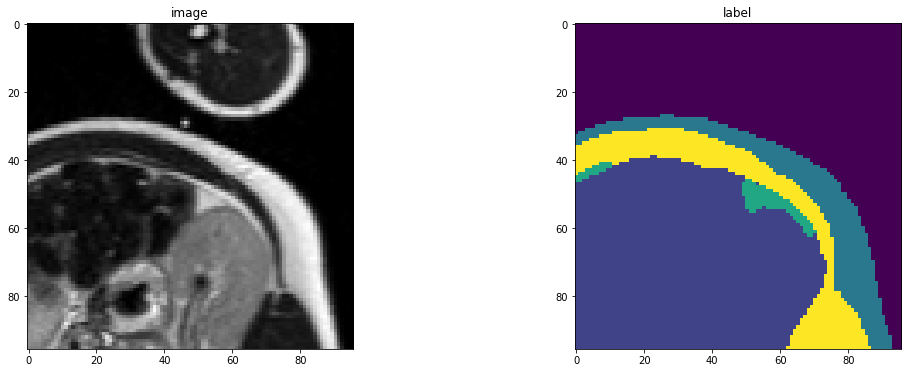

2023-07-25 15:43:32,316 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A052_v1_T2W_seg_829587.nii.gz
2023-07-25 15:43:32,320 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A052_v1_T2W_seg_829587.nii.gz


Training (42 / 70 Steps) (loss=1.97360):  15%|██████████████████                                                                                                      | 3/20 [00:02<00:09,  1.72it/s]

2023-07-25 15:43:32,495 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A022_v4_T2W_829433.nii.gz
2023-07-25 15:43:32,514 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A022_v4_T2W_829433.nii.gz
2023-07-25 15:43:32,535 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A022_v4_T2W_829433.nii.gz
2023-07-25 15:43:32,569 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A022_v4_T2W_829433.nii.gz
2023-07-25 15:43:32,596 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A022_v4_T2W_seg_829587.nii.gz
2023-07-25 15:43:32,601 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A022_v4_T2W_seg_829587.nii.gz
2023-07-25 15:43:32,606 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A022_v4_T2W_seg_829587.nii.gz
2023-07-25 15:43:32,611 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A022_v4_T2W_seg_829587.nii.gz
torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


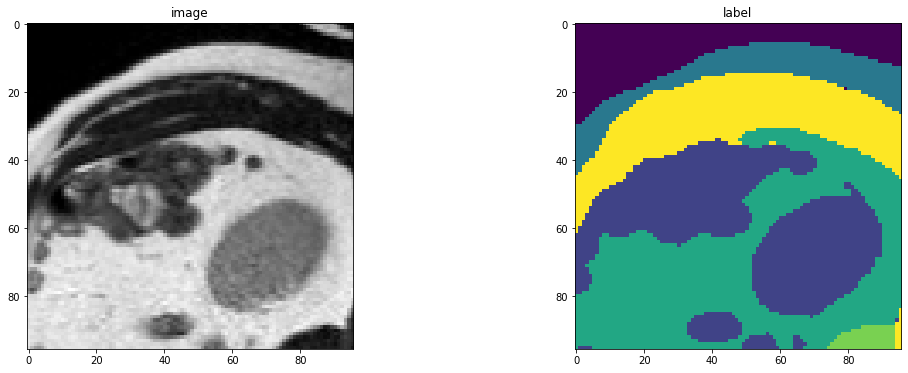

Training (43 / 70 Steps) (loss=2.10338):  20%|████████████████████████                                                                                                | 4/20 [00:02<00:07,  2.04it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


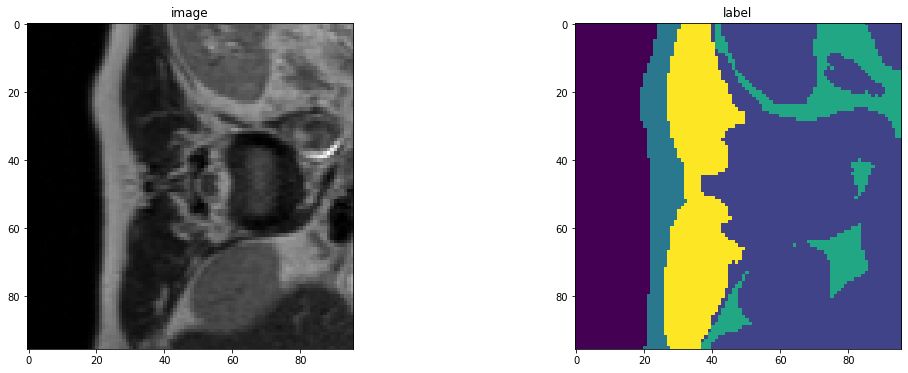

Training (44 / 70 Steps) (loss=1.89163):  25%|██████████████████████████████                                                                                          | 5/20 [00:02<00:06,  2.41it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


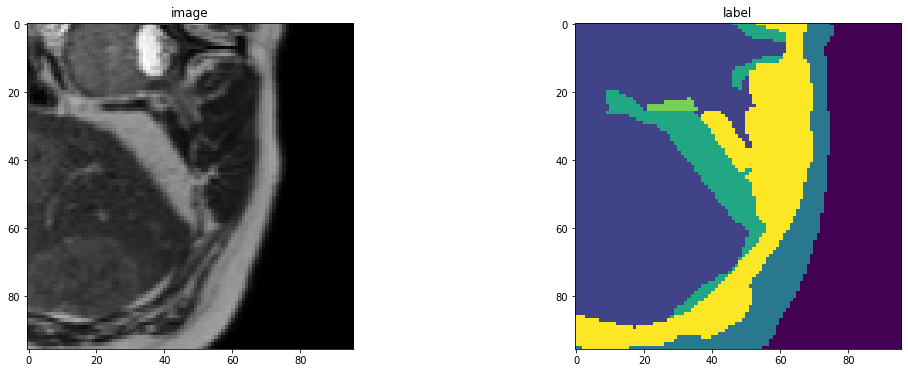

Training (45 / 70 Steps) (loss=1.99983):  30%|████████████████████████████████████                                                                                    | 6/20 [00:03<00:05,  2.38it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


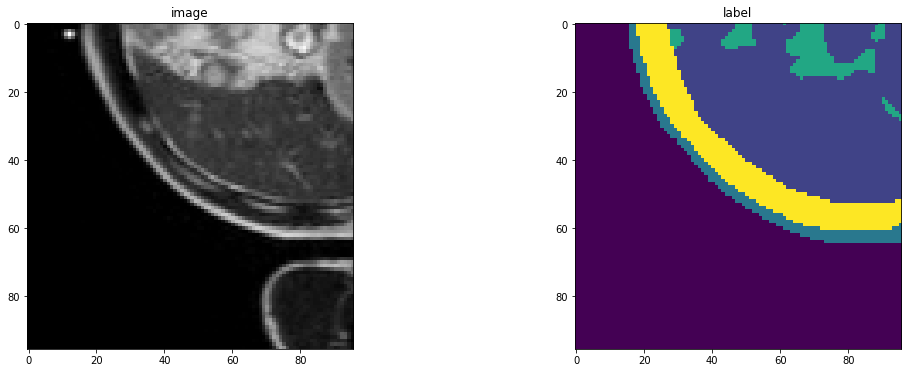

Training (46 / 70 Steps) (loss=2.07671):  35%|██████████████████████████████████████████                                                                              | 7/20 [00:03<00:04,  2.71it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


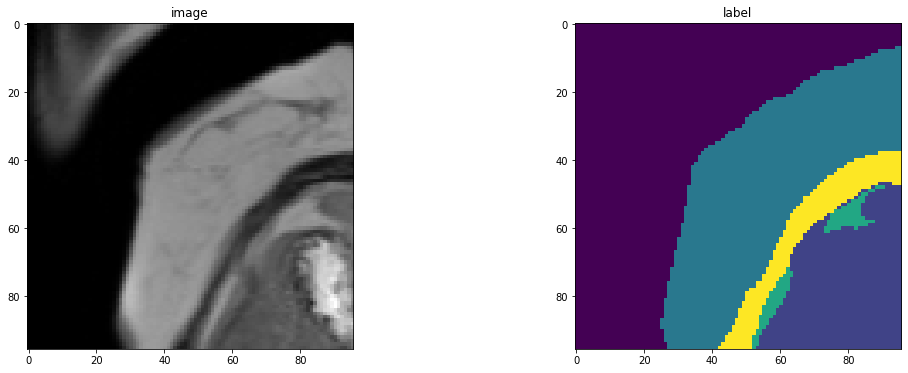

Training (47 / 70 Steps) (loss=2.15043):  40%|████████████████████████████████████████████████                                                                        | 8/20 [00:03<00:04,  2.99it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


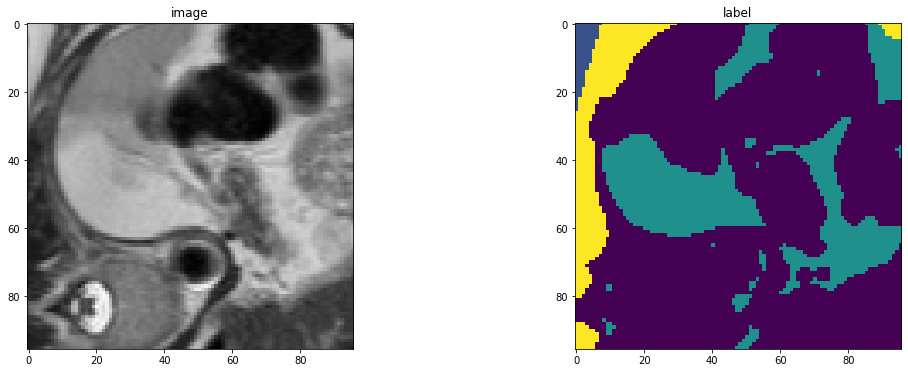

Training (48 / 70 Steps) (loss=2.11783):  45%|██████████████████████████████████████████████████████                                                                  | 9/20 [00:04<00:03,  3.17it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


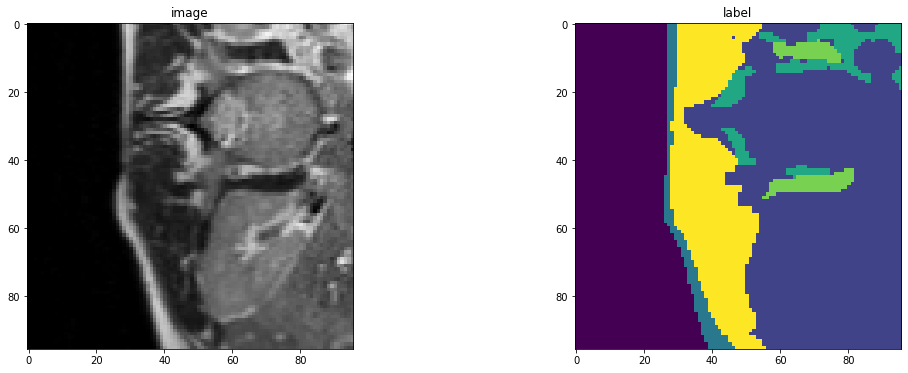

Training (49 / 70 Steps) (loss=1.87043):  50%|███████████████████████████████████████████████████████████▌                                                           | 10/20 [00:04<00:03,  3.23it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


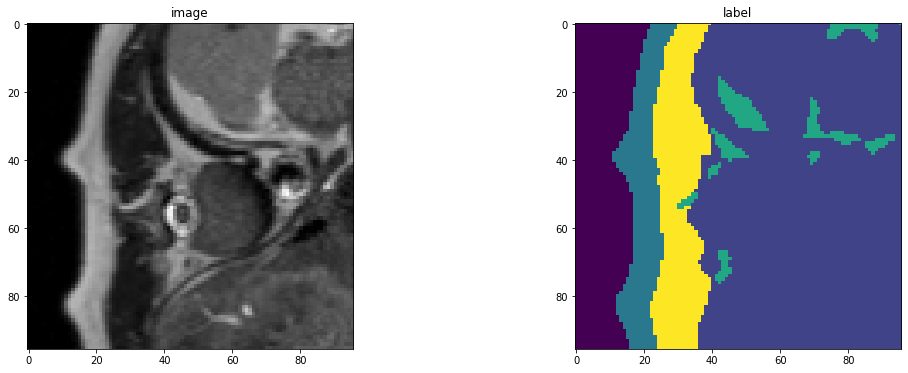

Training (50 / 70 Steps) (loss=2.12292):  55%|█████████████████████████████████████████████████████████████████▍                                                     | 11/20 [00:04<00:02,  3.39it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


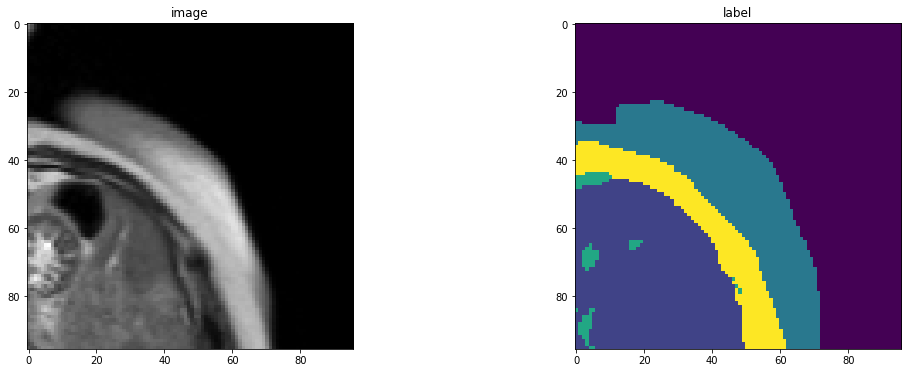

Training (51 / 70 Steps) (loss=1.93046):  60%|███████████████████████████████████████████████████████████████████████▍                                               | 12/20 [00:04<00:02,  3.46it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


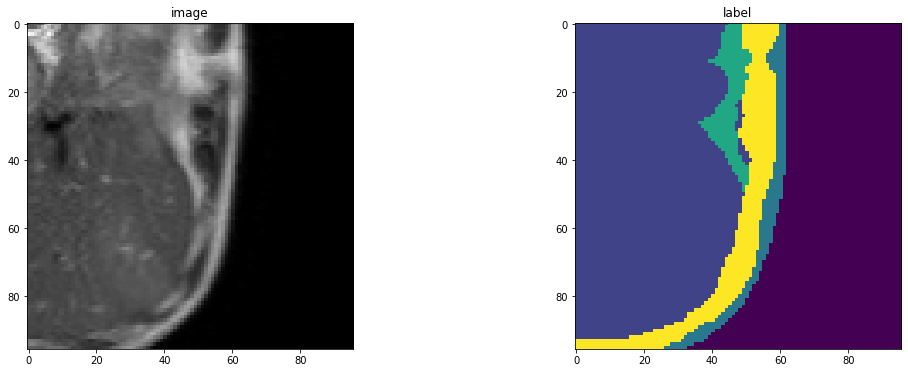

Training (52 / 70 Steps) (loss=1.92548):  65%|█████████████████████████████████████████████████████████████████████████████▎                                         | 13/20 [00:05<00:01,  3.56it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


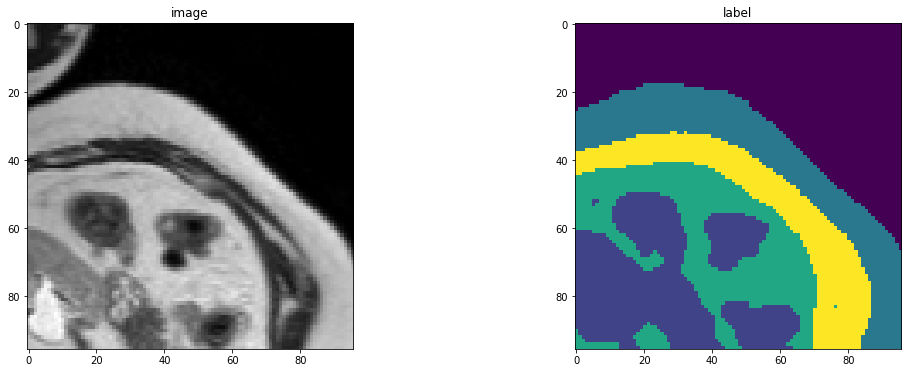

Training (53 / 70 Steps) (loss=1.97246):  70%|███████████████████████████████████████████████████████████████████████████████████▎                                   | 14/20 [00:05<00:01,  3.54it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


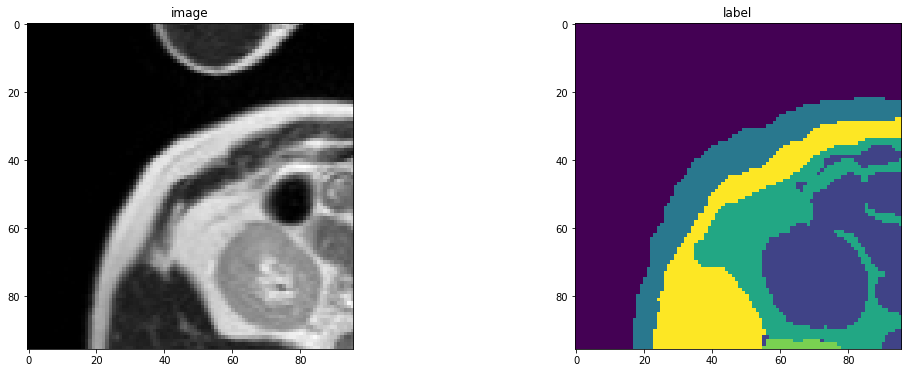

Training (54 / 70 Steps) (loss=2.03085):  75%|█████████████████████████████████████████████████████████████████████████████████████████▎                             | 15/20 [00:05<00:01,  3.56it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


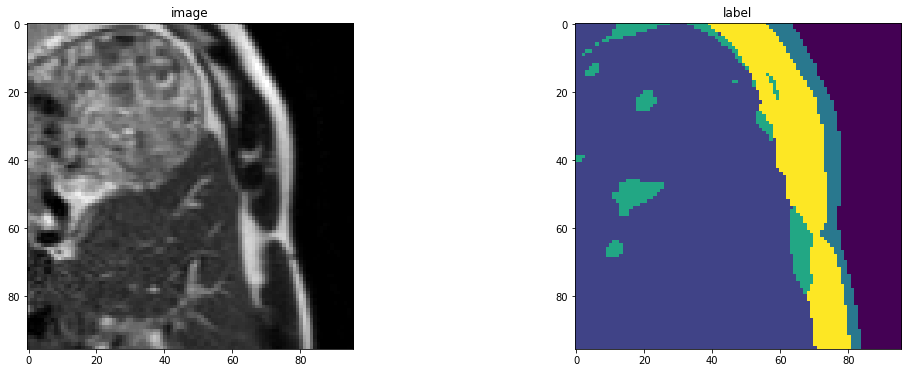

Training (55 / 70 Steps) (loss=1.95183):  80%|███████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/20 [00:05<00:01,  3.56it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


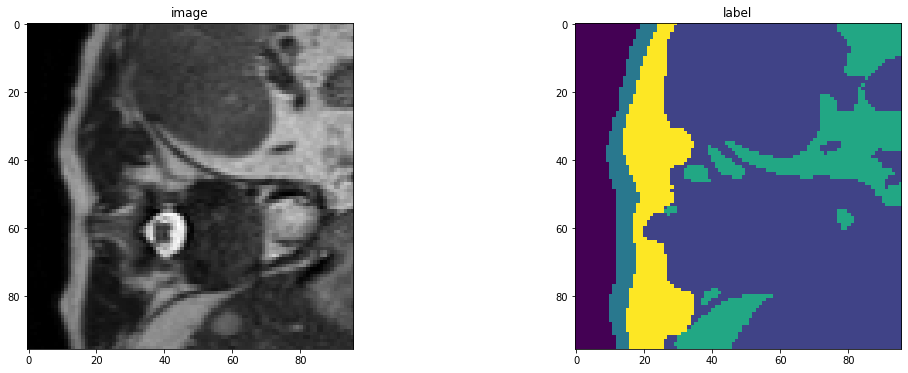

Training (56 / 70 Steps) (loss=2.03963):  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 17/20 [00:06<00:00,  3.64it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


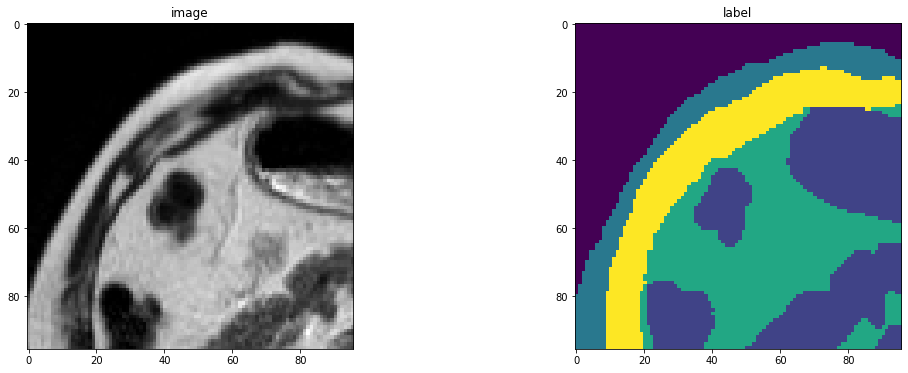

Training (57 / 70 Steps) (loss=2.03448):  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████            | 18/20 [00:06<00:00,  3.70it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


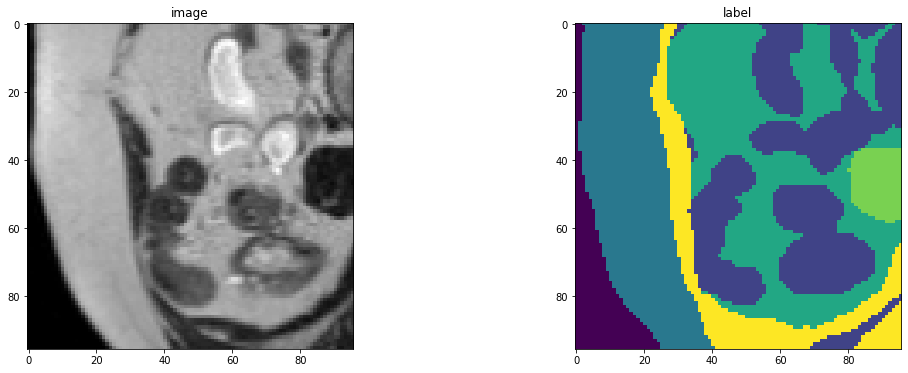

Training (58 / 70 Steps) (loss=2.08520):  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 19/20 [00:06<00:00,  3.74it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


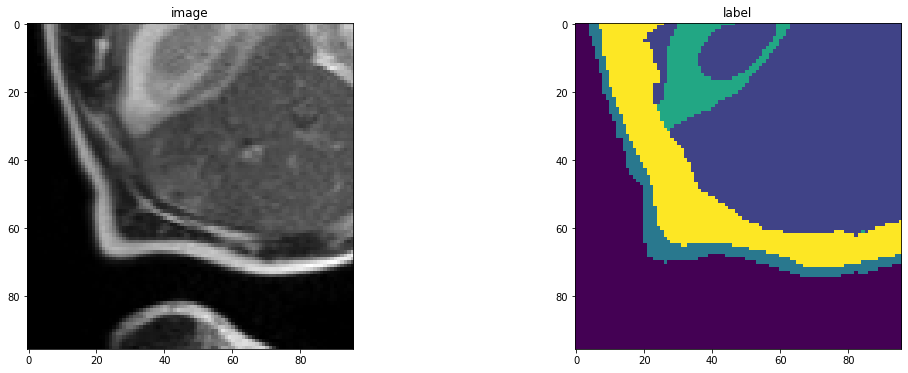

Training (X / X Steps) (loss=X.X):   0%|                                                                                                                                      | 0/20 [00:00<?, ?it/s]

2023-07-25 15:43:37,905 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A009_v4_T2W_829433.nii.gz
2023-07-25 15:43:37,904 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A024_v1_T2W_829433.nii.gz
2023-07-25 15:43:37,904 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A016_v3_T2W_829433.nii.gz
2023-07-25 15:43:37,904 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A037_v1_T2W_829433.nii.gz
2023-07-25 15:43:37,986 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A028_v5_T2W_829433.nii.gz
2023-07-25 15:43:37,981 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A026_v1_T2W_829433.nii.gz
2023-07-25 15:43:37,989 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A009_v4_T2W_829433.nii.gz
2023-07-25 15:43:38,012 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A037_v1_T2W_829433.nii.gz
2023-07-25 15:43:38,015 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A016_v3_T2W_829433

2023-07-25 15:43:38,359 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A033_v3_T2W_829433.nii.gz
2023-07-25 15:43:38,356 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A061_v5_T2W_829433.nii.gz
2023-07-25 15:43:38,343 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A002_v3_T2W_829433.nii.gz
2023-07-25 15:43:38,391 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A022_v4_T2W_829433.nii.gz
2023-07-25 15:43:38,394 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A043_v5_T2W_829433.nii.gz
2023-07-25 15:43:38,390 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A033_v3_T2W_829433.nii.gz
2023-07-25 15:43:38,392 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A029_v4_T2W_829433.nii.gz
2023-07-25 15:43:38,404 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A002_v3_T2W_829433.nii.gz
2023-07-25 15:43:38,406 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A014_v2_T2W_829433

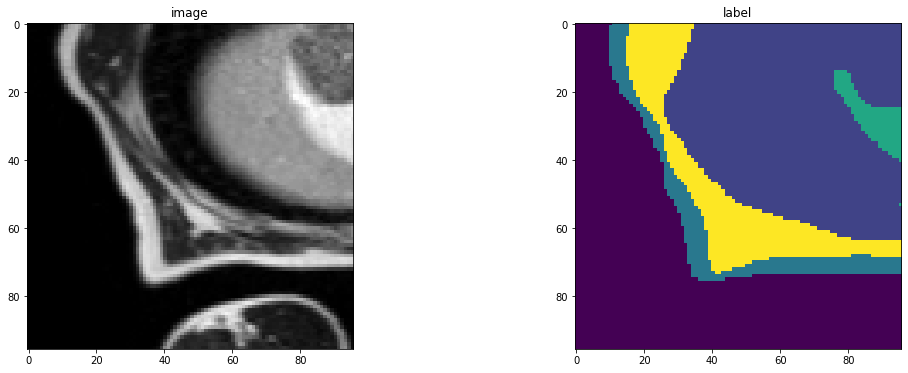

Training (60 / 70 Steps) (loss=2.09681):   5%|██████                                                                                                                  | 1/20 [00:01<00:33,  1.78s/it]

2023-07-25 15:43:39,240 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A052_v1_T2W_829433.nii.gz
2023-07-25 15:43:39,263 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A052_v1_T2W_829433.nii.gz
2023-07-25 15:43:39,283 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A052_v1_T2W_829433.nii.gz
2023-07-25 15:43:39,304 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A052_v1_T2W_829433.nii.gz
2023-07-25 15:43:39,325 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A052_v1_T2W_seg_829587.nii.gz
2023-07-25 15:43:39,330 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A052_v1_T2W_seg_829587.nii.gz
torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


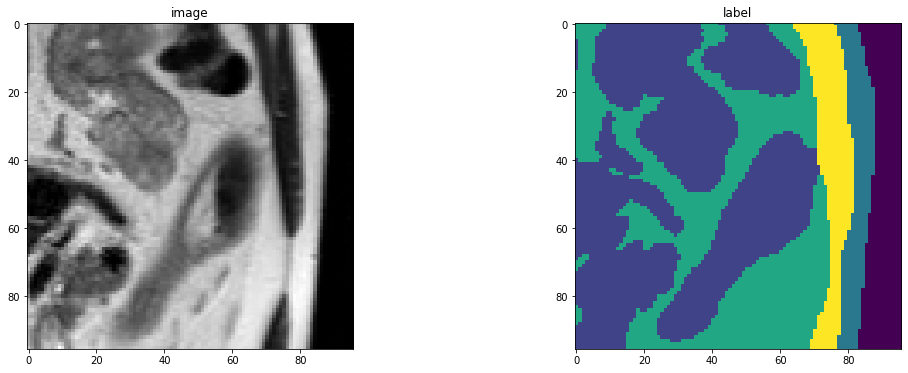

2023-07-25 15:43:39,344 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A052_v1_T2W_seg_829587.nii.gz
2023-07-25 15:43:39,353 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A052_v1_T2W_seg_829587.nii.gz


Training (61 / 70 Steps) (loss=2.21477):  10%|████████████                                                                                                            | 2/20 [00:02<00:16,  1.09it/s]

2023-07-25 15:43:39,550 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A023_v5_T2W_829433.nii.gz
2023-07-25 15:43:39,595 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A023_v5_T2W_829433.nii.gz
2023-07-25 15:43:39,624 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A023_v5_T2W_829433.nii.gz
torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


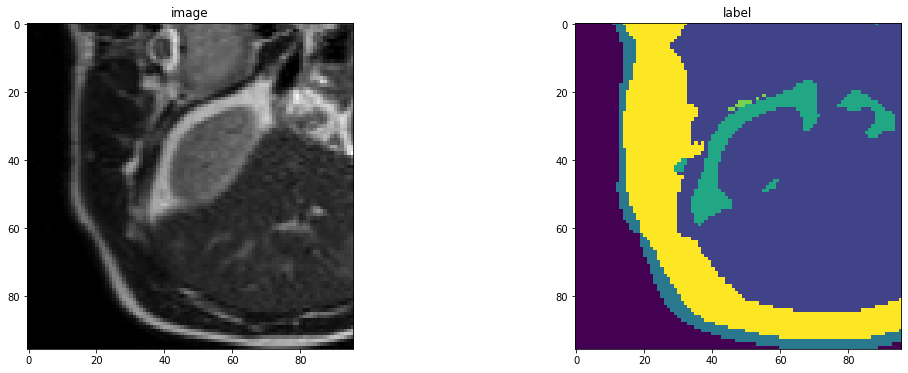

2023-07-25 15:43:39,647 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A023_v5_T2W_829433.nii.gz
2023-07-25 15:43:39,668 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A023_v5_T2W_seg_829587.nii.gz
2023-07-25 15:43:39,673 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A023_v5_T2W_seg_829587.nii.gz
2023-07-25 15:43:39,678 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A023_v5_T2W_seg_829587.nii.gz
2023-07-25 15:43:39,682 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A023_v5_T2W_seg_829587.nii.gz


Training (62 / 70 Steps) (loss=2.02183):  15%|██████████████████                                                                                                      | 3/20 [00:02<00:10,  1.59it/s]

2023-07-25 15:43:39,830 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A051_v2_T2W_829433.nii.gz
2023-07-25 15:43:39,867 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A051_v2_T2W_829433.nii.gz
2023-07-25 15:43:39,895 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A051_v2_T2W_829433.nii.gz
2023-07-25 15:43:39,916 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/A051_v2_T2W_829433.nii.gz
torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


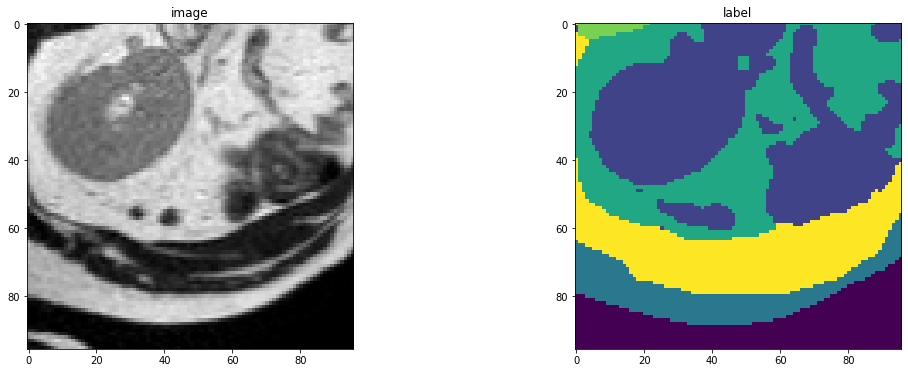

2023-07-25 15:43:39,936 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/segA051_v2_T2W_829587.nii.gz
2023-07-25 15:43:39,942 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/segA051_v2_T2W_829587.nii.gz
2023-07-25 15:43:39,947 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/segA051_v2_T2W_829587.nii.gz
2023-07-25 15:43:39,952 INFO image_writer.py:194 - writing: outMR02_Jul23_Interinputs/segA051_v2_T2W_829587.nii.gz


Training (63 / 70 Steps) (loss=1.98373):  20%|████████████████████████                                                                                                | 4/20 [00:02<00:07,  2.03it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


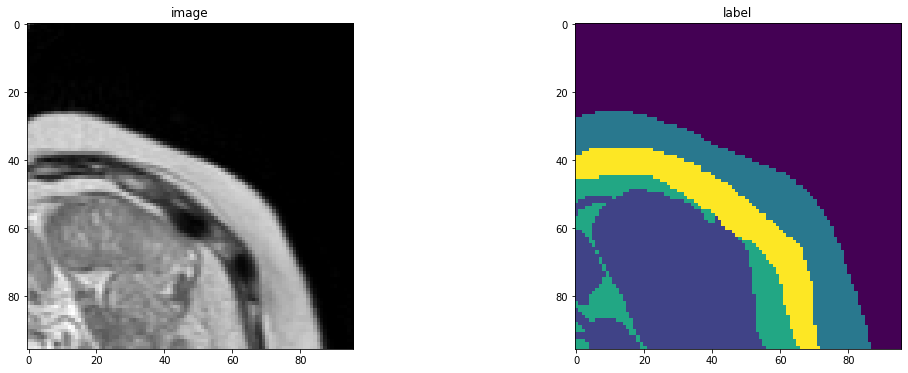

Training (64 / 70 Steps) (loss=1.85251):  25%|██████████████████████████████                                                                                          | 5/20 [00:02<00:06,  2.44it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


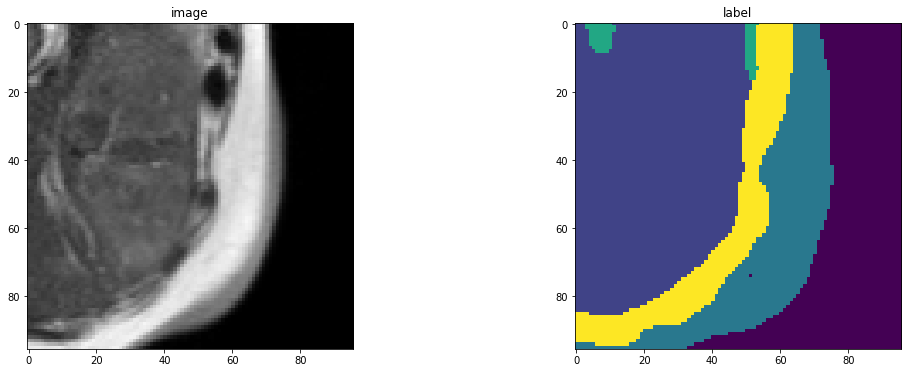

Training (65 / 70 Steps) (loss=1.85054):  30%|████████████████████████████████████                                                                                    | 6/20 [00:03<00:05,  2.78it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


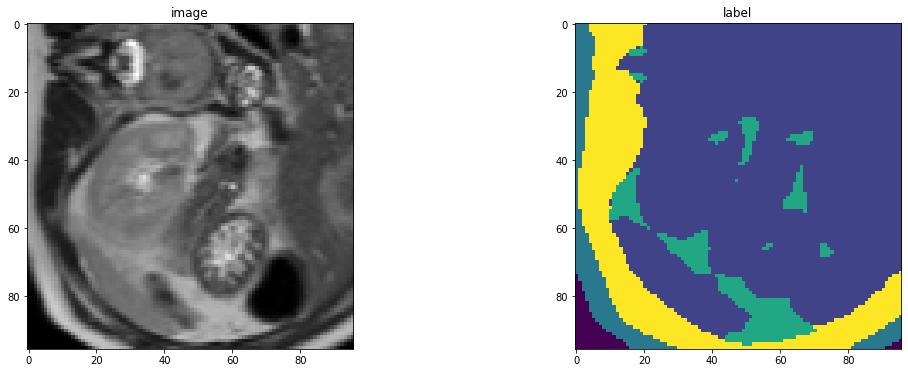

Training (66 / 70 Steps) (loss=1.90699):  35%|██████████████████████████████████████████                                                                              | 7/20 [00:03<00:04,  3.05it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


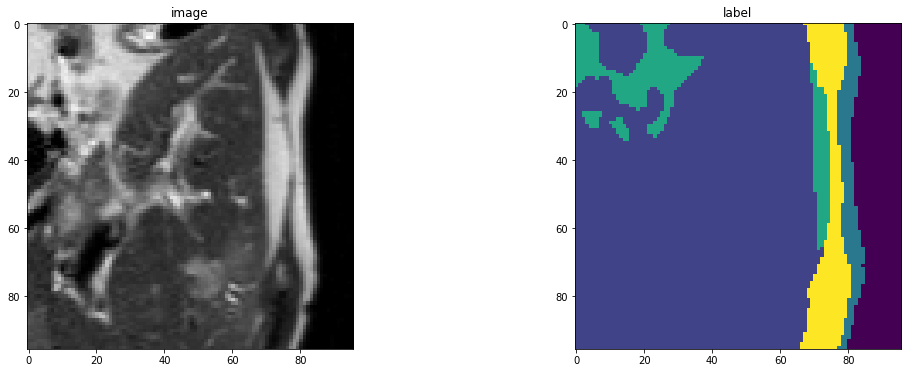

Training (67 / 70 Steps) (loss=1.95675):  40%|████████████████████████████████████████████████                                                                        | 8/20 [00:03<00:03,  3.19it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


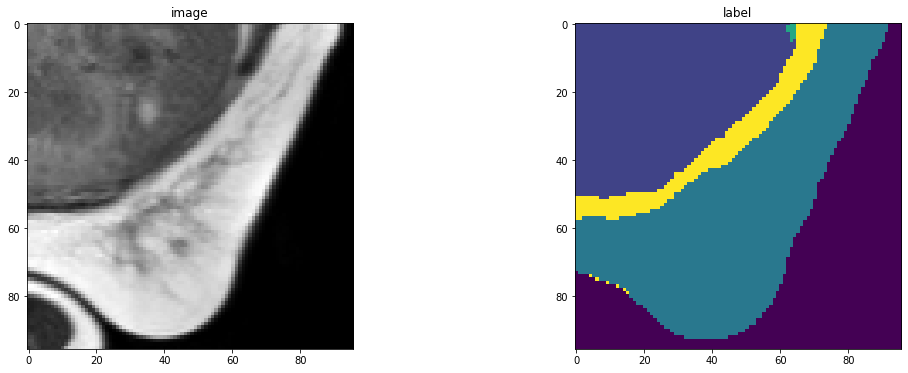

Training (68 / 70 Steps) (loss=1.88300):  45%|██████████████████████████████████████████████████████                                                                  | 9/20 [00:04<00:03,  3.26it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


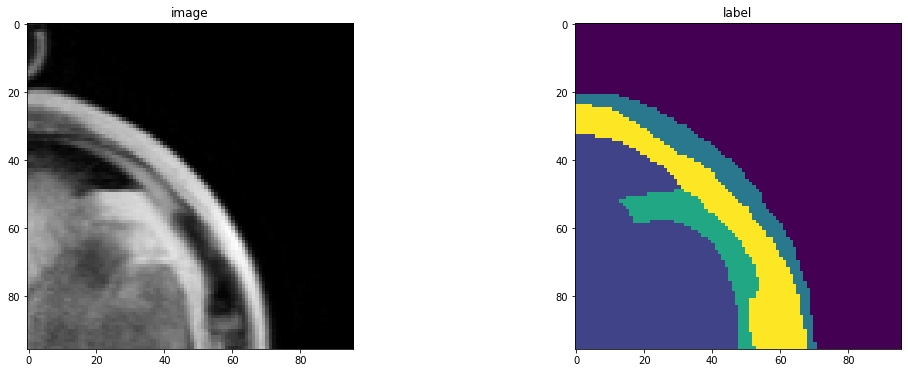

Training (69 / 70 Steps) (loss=1.80178):  50%|███████████████████████████████████████████████████████████▌                                                           | 10/20 [00:04<00:02,  3.34it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


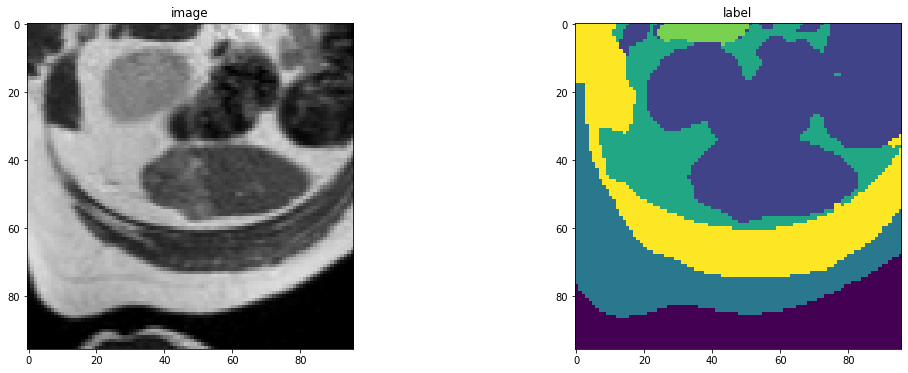

Training (70 / 70 Steps) (loss=1.95974):  55%|█████████████████████████████████████████████████████████████████▍                                                     | 11/20 [00:07<00:10,  1.17s/it]

Model Was Saved ! Current Best Avg. Dice: 0.38464754074811935 Current Avg. Dice: 0.38464754074811935
torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


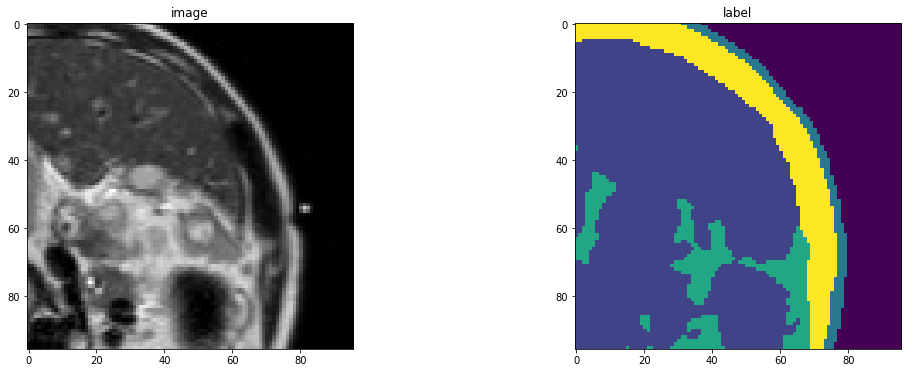

Training (71 / 70 Steps) (loss=1.95526):  60%|███████████████████████████████████████████████████████████████████████▍                                               | 12/20 [00:07<00:07,  1.11it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


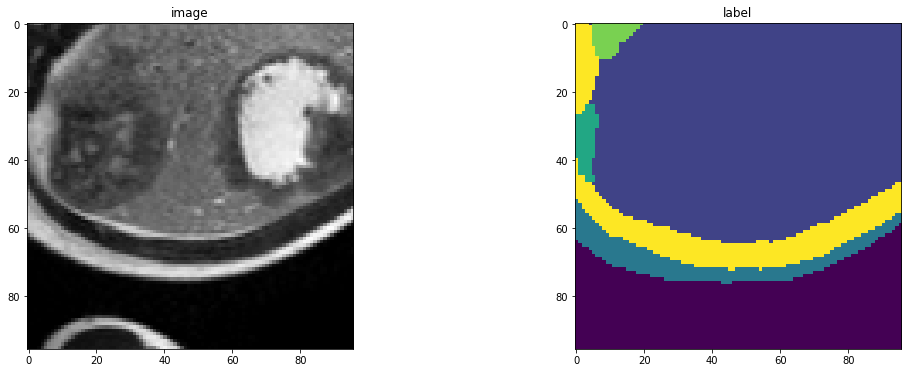

Training (72 / 70 Steps) (loss=1.84134):  65%|█████████████████████████████████████████████████████████████████████████████▎                                         | 13/20 [00:08<00:04,  1.40it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


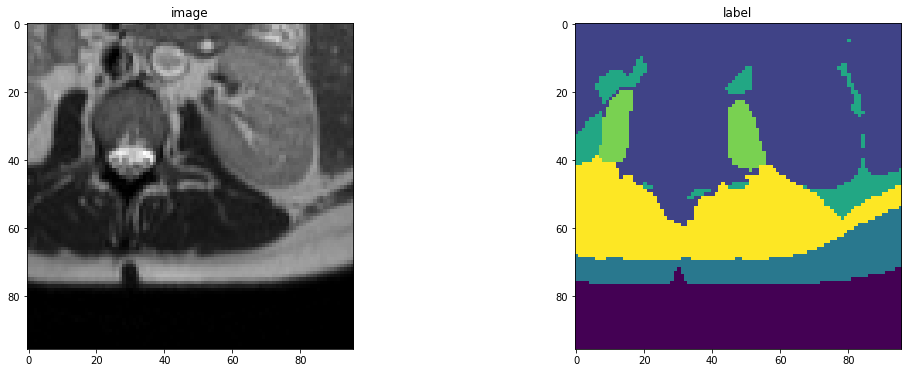

Training (73 / 70 Steps) (loss=2.10061):  70%|███████████████████████████████████████████████████████████████████████████████████▎                                   | 14/20 [00:08<00:03,  1.73it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


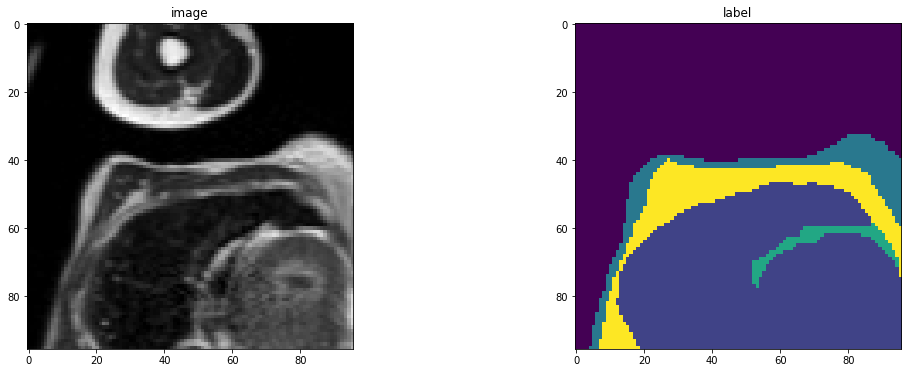

Training (74 / 70 Steps) (loss=1.96377):  75%|█████████████████████████████████████████████████████████████████████████████████████████▎                             | 15/20 [00:08<00:02,  2.07it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


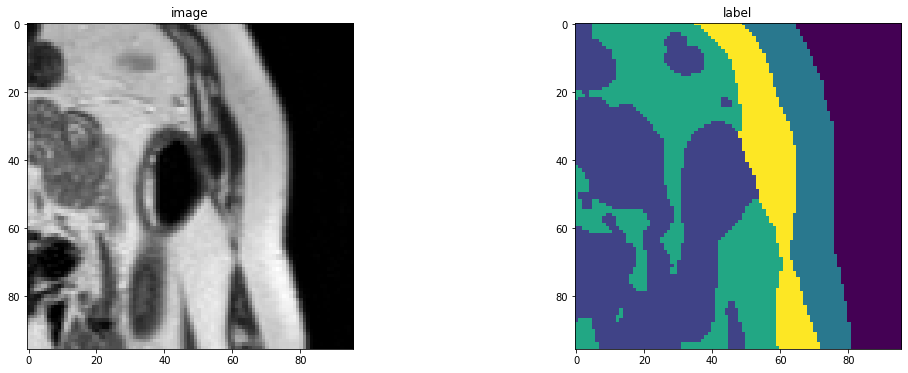

Training (75 / 70 Steps) (loss=1.86948):  80%|███████████████████████████████████████████████████████████████████████████████████████████████▏                       | 16/20 [00:08<00:01,  2.14it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


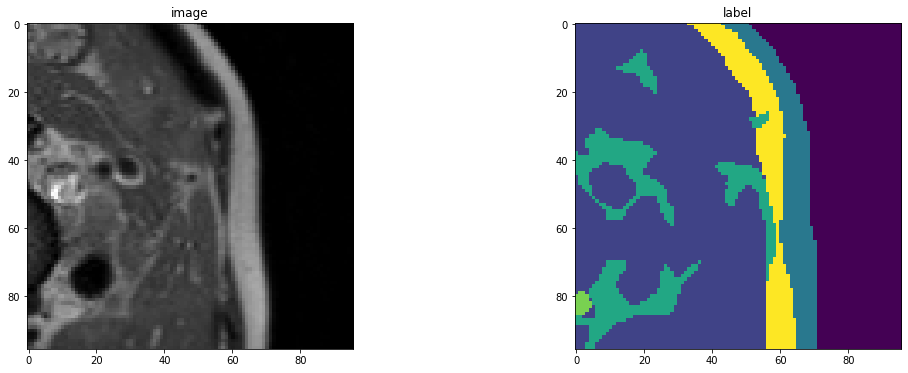

Training (76 / 70 Steps) (loss=1.89788):  85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 17/20 [00:09<00:01,  2.44it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


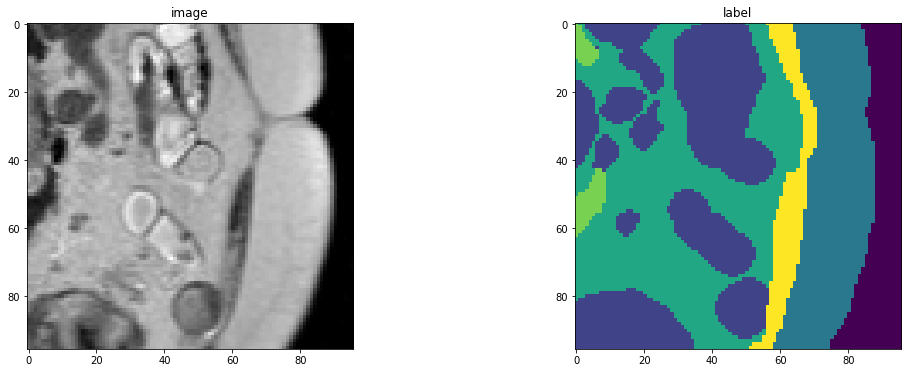

Training (77 / 70 Steps) (loss=2.20204):  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████            | 18/20 [00:09<00:00,  2.69it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


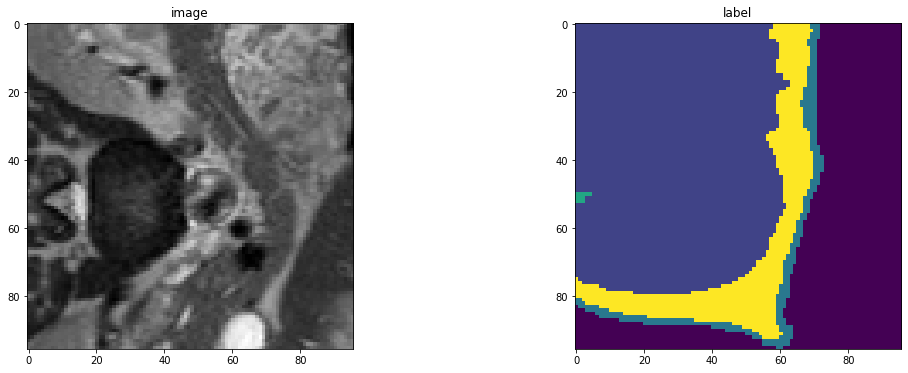

Training (78 / 70 Steps) (loss=2.82891):  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 19/20 [00:09<00:00,  2.93it/s]

torch.Size([4, 1, 96, 96, 16])
torch.Size([4, 1, 96, 96, 16])


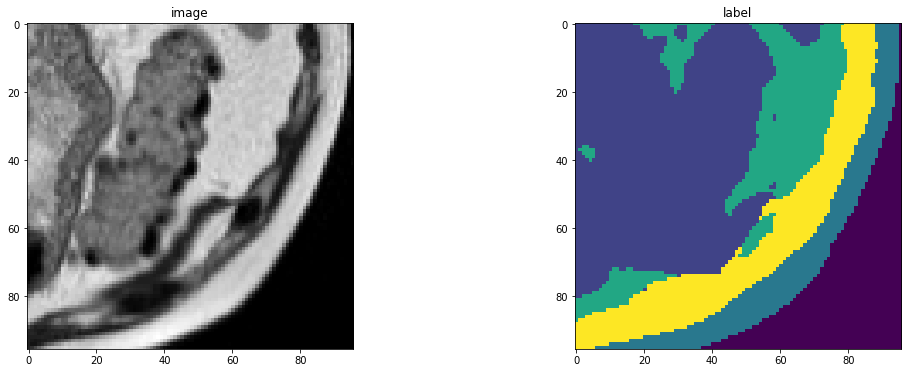

Training (79 / 70 Steps) (loss=1.95360): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:10<00:00,  1.96it/s]


<All keys matched successfully>

In [10]:
def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image"].to(device), batch["label"].to(device))
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 16), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val


def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].to(device), batch["label"].to(device))
        print(x.shape)
        print(y.shape)
        plt.figure("image", (18, 6))
        plt.subplot(1, 2, 1)
        plt.title("image")
        plt.imshow(x[3,0,:,:,4].detach().cpu(), cmap="gray")
        plt.subplot(1, 2, 2)
        plt.title("label")
        plt.imshow(y[3,0,:,:,4].detach().cpu())
        plt.show()
        logit_map = model(x)
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(
                    model.state_dict(), os.path.join(data_dir, "IntermedOuts_multiclassUNetR_MR02_May23.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
        
    return global_step, dice_val_best, global_step_best


max_iterations = 70
eval_num = 500
post_label = AsDiscrete(to_onehot=6)
post_pred = AsDiscrete(argmax=True, to_onehot=6)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )
#     print('I am waiting....')
#     time.sleep(1)
model.load_state_dict(torch.load(os.path.join(data_dir, "IntermedOuts_multiclassUNetR_MR02_May23.pth")))

In [11]:
# print(
#     f"train completed, best_metric: {dice_val_best:.4f} "
#     f"at iteration: {global_step_best}"
# )

In [12]:
# 6062500/380133
# 12062500/731025
# 250*250*49
# 12062500/(250*250)

### Plot the loss and metric

In [13]:
# plt.figure("train", (12, 6))
# plt.subplot(1, 2, 1)
# plt.title("Iteration Average Loss")
# x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
# y = epoch_loss_values
# plt.xlabel("Iteration")
# plt.plot(x, y)
# plt.subplot(1, 2, 2)
# plt.title("Val Mean Dice")
# x = [eval_num * (i + 1) for i in range(len(metric_values))]
# y = metric_values
# plt.xlabel("Iteration")
# plt.plot(x, y)
# plt.show()

### Check best model output with the input image and label

In [14]:
# case_num = 0
# model.load_state_dict(torch.load(os.path.join(data_dir, "IntermedOuts_multiclassUNetR_MR02_May23.pth")))
# model.eval()
# with torch.no_grad():
#     img_name = os.path.split(val_ds[case_num]["image_meta_dict"]["filename_or_obj"])[1]
#     img = val_ds[case_num]["image"]
#     label = val_ds[case_num]["label"]
#     val_inputs = torch.unsqueeze(img, 1).to(device)
#     val_labels = torch.unsqueeze(label, 1).to(device)
#     val_outputs = sliding_window_inference(
#         val_inputs, (96, 96, 48), 4, model, overlap=0.8
#     )
#     plt.figure("check", (18, 6))
#     plt.subplot(1, 3, 1)
#     plt.title("image")
#     plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, 5], cmap="gray")
#     plt.subplot(1, 3, 2)
#     plt.title("label")
#     plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, 5])
#     plt.subplot(1, 3, 3)
#     plt.title("output")
#     plt.imshow(
#         torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 5]
#     )
#     plt.show()
    

In [15]:
# val_inputs.shape

### Inference on test images

In [16]:
# if directory is None:
#     shutil.rmtree(root_dir)

In [17]:
# import glob
# from monai.data import Dataset
# from monai.handlers.utils import from_engine
# from monai.transforms import (
#     AsDiscrete,
#     AsDiscreted,
#     EnsureChannelFirstd,
#     Compose,
#     CropForegroundd,
#     LoadImaged,
#     Orientationd,
#     RandCropByPosNegLabeld,
#     SaveImaged,
#     ScaleIntensityRanged,
#     Spacingd,
#     EnsureTyped,
#     EnsureType,
#     Invertd,
# )

# test_images = sorted(
#     glob.glob(os.path.join(data_dir, "imagesTs/AllVisits", "*.nii.gz")))

# test_data = [{"image": image} for image in test_images]


# test_org_transforms = Compose(
#     [
#         LoadImaged(keys="image"),
#         EnsureChannelFirstd(keys="image"),
#         Orientationd(keys=["image"], axcodes="RAS"),
#         Spacingd(keys=["image"], pixdim=(
#             1.5, 1.5, 2.0), mode="bilinear"),
#         ScaleIntensityRanged(
#             keys=["image"], a_min=0, a_max=200,
#             b_min=0.0, b_max=1.0, clip=False,
#         ),
#         CropForegroundd(keys=["image"], source_key="image"),
#         EnsureTyped(keys="image"),
#     ]
# )

# test_org_ds = Dataset(
#     data=test_data, transform=test_org_transforms)

# test_org_loader = DataLoader(test_org_ds, batch_size=1, num_workers=4)

# post_transforms = Compose([
#     EnsureTyped(keys="pred"),
#     Invertd(
#         keys="pred",
#         transform=test_org_transforms,
#         orig_keys="image",
#         meta_keys="pred_meta_dict",
#         orig_meta_keys="image_meta_dict",
#         meta_key_postfix="meta_dict",
#         nearest_interp=False,
#         to_tensor=True,
#     ),
#     AsDiscreted(keys="pred", argmax=True, to_onehot=6),
#     SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./outMR02_Jul23_IntermedOuts", output_postfix="seg", resample=False, separate_folder=False),
# ])

In [18]:
# print(data_dir)

In [19]:
# # # uncomment the following lines to visualize the predicted results
# from monai.transforms import LoadImage
# loader = LoadImage()

# model.load_state_dict(torch.load(
#     os.path.join(data_dir, "IntermedOuts_multiclassUNetR_MR02_May23.pth")))
# model.eval()

# with torch.no_grad():
#     for test_data in test_org_loader:
#         test_inputs = test_data["image"].to(device)
#         roi_size = (96, 96, 48)
#         sw_batch_size = 4
#         test_data["pred"] = sliding_window_inference(
#             test_inputs, roi_size, sw_batch_size, model, overlap=0.8)

#         test_data = [post_transforms(i) for i in decollate_batch(test_data)]

# #         # uncomment the following lines to visualize the predicted results
#         test_output = from_engine(["pred"])(test_data)

#         original_image = loader(test_data[0]["image_meta_dict"]["filename_or_obj"])[0]

#         plt.figure("check", (18, 6))
#         plt.subplot(1, 2, 1)
#         plt.imshow(original_image[:, :, 8], cmap="gray")
#         plt.subplot(1, 2, 2)
#         plt.imshow(test_output[0].detach().cpu()[5, :, :, 8])
#         plt.show()

In [20]:
# # Testing code modified  (Based on validation block)

# from monai.transforms import LoadImage
# loader = LoadImage()

# model.load_state_dict(torch.load(
#     os.path.join(data_dir, "IntermedOuts_multiclassUNetR_MR02_May23.pth")))
# model.eval()

# with torch.no_grad():
#     for test_data in test_org_loader:
#         test_inputs = test_data["image"].to(device)
#         roi_size = (96, 96, 48)
#         sw_batch_size = 4
#         test_outputs = sliding_window_inference(
#             test_inputs, roi_size, sw_batch_size, model, overlap=0.8
#     )
# #     plt.figure("check", (18, 6))
# #     plt.subplot(1, 2, 1)
# #     plt.title("image")
# #     plt.imshow(test_inputs.cpu().numpy()[0, 0, :, :, 40], cmap="gray")
# #     plt.subplot(1, 2, 2)
# #     plt.title("output")
# #     plt.imshow(
# #         torch.argmax(test_outputs, dim=1).detach().cpu()[0, :, :, 40]
# #     )
# #     plt.show()      

In [21]:
!tar -cvzf outMR02_Jul23_Interinputs_4and8mm_resample4mm.tar.gz outMR02_Jul23_Interinputs

outMR02_Jul23_Interinputs/
outMR02_Jul23_Interinputs/A034_v5_T2W_829433.nii.gz
outMR02_Jul23_Interinputs/A026_v1_T2W_829433.nii.gz
outMR02_Jul23_Interinputs/segA029_v4_T2W_829587.nii.gz
outMR02_Jul23_Interinputs/A071_v2_T2W_829433.nii.gz
outMR02_Jul23_Interinputs/A052_v1_T2W_829433.nii.gz
outMR02_Jul23_Interinputs/A051_v2_T2W_829433.nii.gz
outMR02_Jul23_Interinputs/A065_v2_T2W_seg_829587.nii.gz
outMR02_Jul23_Interinputs/segA034_v5_T2W_829587.nii.gz
outMR02_Jul23_Interinputs/segA043_v5_T2W_829587.nii.gz
outMR02_Jul23_Interinputs/A024_v1_T2W_seg_829587.nii.gz
outMR02_Jul23_Interinputs/A009_v4_T2W_829433.nii.gz
outMR02_Jul23_Interinputs/A022_v4_T2W_seg_829587.nii.gz
outMR02_Jul23_Interinputs/A022_v4_T2W_829433.nii.gz
outMR02_Jul23_Interinputs/segA028_v5_T2W_829587.nii.gz
outMR02_Jul23_Interinputs/A013_v1_T2W_829433.nii.gz
outMR02_Jul23_Interinputs/A014_v2_T2W_829433.nii.gz
outMR02_Jul23_Interinputs/A014_v2_T2W_seg_829587.nii.gz
outMR02_Jul23_Interinputs/A029_v4_T2W_829433.nii.gz
outMR02_J

In [22]:
# !pwd

In [23]:
# plt.figure("check", (18, 6))
# plt.subplot(1, 2, 1)
# plt.title("image")
# plt.imshow(test_inputs.cpu().numpy()[0, 0, :, :, 20], cmap="gray")
# plt.subplot(1, 2, 2)
# plt.title("output")
# plt.imshow(
#     torch.argmax(test_outputs, dim=1).detach().cpu()[0, :, :, 20]
# )
# plt.show()

In [24]:
# print(test_output[0].shape)

In [25]:
# slno = 20
# plt.figure("check1", (18, 6))
# plt.imshow(original_image[:, :, slno], cmap="gray")
# plt.figure("check2", (18, 6))
# plt.subplot(3, 3, 1)
# plt.imshow(test_output[0].detach().cpu()[0, :, :, slno])
# plt.subplot(3, 3, 2)
# plt.imshow(test_output[0].detach().cpu()[1, :, :, slno])
# plt.subplot(3, 3, 3)
# plt.imshow(test_output[0].detach().cpu()[2, :, :, slno])
# plt.subplot(3, 3, 4)
# plt.imshow(test_output[0].detach().cpu()[3, :, :, slno])
# plt.subplot(3, 3, 5)
# plt.imshow(test_output[0].detach().cpu()[4, :, :, slno])
# plt.subplot(3, 3, 6)
# plt.imshow(test_output[0].detach().cpu()[5, :, :, slno])
# plt.subplot(3, 3, 7)
# plt.imshow(test_output[0].detach().cpu()[6, :, :, slno])
# plt.subplot(3, 3, 8)
# plt.imshow(test_output[0].detach().cpu()[7, :, :, slno])
# plt.subplot(3, 3, 9)
# plt.imshow(test_output[0].detach().cpu()[8, :, :, slno])
# plt.show()